In [9]:
# Import stuff
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm

from jaxtyping import Float
from functools import partial

# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

import torch
torch.set_grad_enabled(False)

In [10]:
import torch ,os
from utils import data_loader, misc
from collections import defaultdict

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

torch.set_grad_enabled(False)
misc.seed_everything(555)

In [11]:
# load model and tokenizer
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained("Qwen/Qwen2.5-3B")
num_layers = model.cfg.n_layers
# tokenizer = Qwen2Tokenizer.from_pretrained("Qwen/Qwen2.5-3B")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen2.5-3B into HookedTransformer


In [12]:
_, _, edited_phrases = data_loader.wiki_loader(num_samples=2000000)

In [27]:
schemas = {
    # 'swap_is_are': data_loader.Scheme(source= 'is',
    #                                      target= 'are').swap_words,
    # 'swap_was_were': data_loader.Scheme(source= 'was',
    #                                      target= 'were').swap_words,
    # 'swap_a_the': data_loader.Scheme(source= 'a',
    #                                      target= 'the').swap_words,
    # 'drop_a': data_loader.Scheme(source= 'a',
    #                                      target= '').drop_words,
    'char_edit': data_loader.Scheme().char_edit,
}

# Cont. Gen

In [14]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return  intersection / union

def get_acc(info_lst, return_all=False):
    jcc_ult = []
    acc_ult = []

    for data in info_lst:
        acc_lst = []
        jc_lst = []
        for step in data.keys():
            copy = data[step]['copy']
            original = data[step]['original']

            jaccard_score = jaccard_similarity(copy, original)
            jc_lst.append(jaccard_score)

            acc_score = 1 if copy[0] == original[0] else 0
            acc_lst.append(acc_score)

        jcc_ult.append(jc_lst)
        acc_ult.append(acc_lst)
    
    def cal_avg(lsts):
        avg_lst = []
        for lst in lsts:
            if len(lst) == 0:
                continue
            avg_lst.append(sum(lst) / len(lst))
        return sum(avg_lst) / len(avg_lst)

    avg_jcc = cal_avg(jcc_ult)
    avg_acc = cal_avg(acc_ult)

    if return_all:
        return avg_jcc, avg_acc, jcc_ult, acc_ult

    return avg_jcc, avg_acc

In [24]:
from utils.misc import (
    get_top_k,
)
from utils.n_grams_cp import detect_ngram_copy

def ngram_cg(model, skip_up_to, edited_phrases, schema, n=5, k=100, gen_num=20):
    # print("n-gram: ", n)
    # print("Skip layers: ", skip_up_to)

    total_patched_words = 20
    total_solvable_og = 0
    return_scores = []    
    false_cases = 0

    for edited in edited_phrases:
        if false_cases == 10:
            break

        if total_solvable_og == 100:
            break
        
        outputs = schema(edited)
        if not outputs:
            continue

        # preprocess text
        corrupted_text, pre_isare, correct_tobe = outputs[0]
        source, target = outputs[1]
        prompt = f"Please fix grammar of the following text: '{corrupted_text}'. The correct text is: {pre_isare}"
        prompt_tokens = model.to_tokens(prompt, prepend_bos=False)

        # run on the prompt once with cache to store activations to patch in later
        og_logits, og_cache = model.run_with_cache(prompt_tokens)
        # get the top k tokens
        og_topk_indices = get_top_k(og_logits, k)
        # get the highest prob token
        og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

        # check if model can solve the task
        decoded_og_next_token = model.to_string(og_next_token)[0]
        if target in decoded_og_next_token and correct_tobe == target and target != '':
            total_solvable_og += 1
        elif source in decoded_og_next_token and correct_tobe == source:
            total_solvable_og += 1
        else:
            continue

        og_topk_lst = []
        # concat next tokens
        og_prompt_tokens = torch.cat([prompt_tokens, og_next_token], dim=1)  
        og_topk_lst.append(og_topk_indices)
        # iterate to gen next gen_num tokens
        for id in range(gen_num):
            logits = model(og_prompt_tokens)
            # get the top k tokens
            og_topk_indices = get_top_k(logits, k)
            # get the highest prob token
            og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)
            # concat next tokens
            og_prompt_tokens = torch.cat([og_prompt_tokens, og_next_token], dim=1)  
            # store
            og_topk_lst.append(og_topk_indices)
            # og_next_token_lst.append(og_next_token)
        
        patching_succeed_flag = True
        # start on patching model
        score_list_dict = defaultdict(list)
        # score_list = []        
        # pt_topk_lst = []
        # pt_next_token_lst = []
        print_flg = None
        for num_word2patch in range(total_patched_words, total_patched_words+1):
            if not patching_succeed_flag:
                break

            dict_pred_info = defaultdict(dict)

            pos_matched = []
            pos_current = []
            # total_matches = []

            for id in range(num_word2patch):
                assert id < len(prompt_tokens[0])
                pos_matched.append(detect_ngram_copy(prompt_tokens[:, :len(prompt_tokens[0])-id], n=n)[0])
                pos_current.append(len(prompt_tokens[0])-id-1)
            
            # if there any none of finding ngram, break the experiment with current prompt
            # as it does not have enough tokens
            if None in pos_matched or len(pos_matched) == 0:
                total_solvable_og -= 1
                patching_succeed_flag = False
                break        

            # start hooking
            def residual_stream_patching_hook(
                resid_pre: Float[torch.Tensor, "batch pos d_model"],
                hook: HookPoint,
                pos_matched: list,
                pos_current: list
            ) -> Float[torch.Tensor, "batch pos d_model"]:
                # Each HookPoint has a name attribute giving the name of the hook.
                clean_resid_pre = og_cache[hook.name]
                resid_pre[:, pos_current, :] = clean_resid_pre[:, pos_matched, :]
                return resid_pre
            
            # Use functools.partial to create a temporary hook function with the position fixed
            temp_hook_fn = partial(residual_stream_patching_hook, pos_matched=pos_matched, pos_current=pos_current)

            pt_prompt_tokens = prompt_tokens.clone()
            for idx in range(gen_num+1):
                # Run the model with the patching hook
                patched_logits = model.run_with_hooks(pt_prompt_tokens, fwd_hooks=[
                    (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                ])
                # get the top k tokens
                tp_topk_indices = get_top_k(patched_logits, k)
                # get the highest prob token
                tp_next_token = torch.tensor([tp_topk_indices[0]]).unsqueeze(0).to(og_logits.device)
                # concat next tokens
                pt_prompt_tokens = torch.cat([pt_prompt_tokens, tp_next_token], dim=1)  

                dict_pred_info[idx]['original'] = og_topk_lst[idx]
                dict_pred_info[idx]['copy'] = tp_topk_indices
        
            jcc_avg, acc_avg, jcc_all, acc_all = get_acc([dict_pred_info], return_all= True)
            if acc_avg < 1:
                print_flg = True
            score_list_dict["acc2"].append(acc_avg)
            score_list_dict["jcc"].append(jcc_avg)
            score_list_dict["acc_all"].append(acc_all)
            score_list_dict["jcc_all"].append(jcc_all)
            # print(score_list_dict)
        
        if patching_succeed_flag:
            return_scores.append(score_list_dict)

        if print_flg:
            false_cases += 1
            print('Unpatched:')
            print(model.to_string(og_prompt_tokens))
            print('Patched:')
            print(model.to_string(pt_prompt_tokens))
            print('-------------------------------')
            
        

    return return_scores

In [62]:
def ngram_char_edits_cg(model, skip_up_to, edited_phrases, schema, n=5, k=100, gen_num=20):
    # print("n-gram: ", n)
    # print("Skip layers: ", skip_up_to)

    return_scores = [] 
    total_patched_words = 5
    total_solvable_dict = {
        'swap': 0,
        'drop': 0,
        'add': 0
    }
    false_cases = 0

    for edited in edited_phrases:
        if total_solvable_dict['swap'] == 33 and \
            total_solvable_dict['drop'] == 33 and \
                total_solvable_dict['add'] == 34:
            break

        if false_cases == 10:
            break
        
        return_outputs = schema(text = edited, model = model)
        if not return_outputs:
            continue

        # preprocess text
        for method, outputs in return_outputs.items():
            if total_solvable_dict[method] == 33 and method in ['swap', 'drop']:
                continue
            if total_solvable_dict[method] == 34 and method in ['add']:
                continue
            corrupted_sentence, decoded_up_to, ground_truth_next = outputs
            prompt = f"Please fix grammar of the following text: '{corrupted_sentence}'. The correct text is: {decoded_up_to}"
            prompt_tokens = model.to_tokens(prompt, prepend_bos=False)

            # run on the prompt once with cache to store activations to patch in later
            og_logits, og_cache = model.run_with_cache(prompt_tokens)
            # get the top k tokens
            og_topk_indices = get_top_k(og_logits, k)
            # get the highest prob token
            og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

            # check if model can solve the task
            decoded_og_next_token = model.to_string(og_next_token)[0]
            if ground_truth_next in decoded_og_next_token: 
                total_solvable_dict[method] += 1
            else:
                # total_unsolvable += 1
                continue

            og_topk_lst = []
            # concat next tokens
            og_prompt_tokens = torch.cat([prompt_tokens, og_next_token], dim=1)  
            og_topk_lst.append(og_topk_indices)
            # iterate to gen next gen_num tokens
            for id in range(gen_num):
                logits = model(og_prompt_tokens)
                # get the top k tokens
                og_topk_indices = get_top_k(logits, k)
                # get the highest prob token
                og_prompt_tokens = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)
                # concat next tokens
                og_prompt_tokens = torch.cat([og_prompt_tokens, og_prompt_tokens], dim=1)  
                # store
                og_topk_lst.append(og_topk_indices)
                og_next_token = torch.cat([og_next_token, og_prompt_tokens], dim=1)  
                # og_next_token_lst.append(og_next_token)

            patching_succeed_flag = True
            score_list_dict =  defaultdict(list)
            
            # start on patching model
            print_flg = None
            for num_word2patch in range(total_patched_words, total_patched_words+1):
                if not patching_succeed_flag:
                    break

                dict_pred_info = defaultdict(dict)

                pos_matched = []
                pos_current = []
                total_matches = []

                for id in range(num_word2patch):
                    assert id < len(prompt_tokens[0])
                    pos_matched.append(detect_ngram_copy(prompt_tokens[:, :len(prompt_tokens[0])-id], n=n)[0])
                    pos_current.append(len(prompt_tokens[0])-id-1)

                # if there any none of finding ngram, break the experiment with current prompt
                # as it does not have enough tokens
                if None in pos_matched:
                    total_solvable_dict[method] -= 1
                    patching_succeed_flag = False
                    break            
                    
                # start hooking
                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    pos_matched: list,
                    pos_current: list
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, pos_current, :] = clean_resid_pre[:, pos_matched, :]
                    return resid_pre
                
                # Use functools.partial to create a temporary hook function with the position fixed
                temp_hook_fn = partial(residual_stream_patching_hook, pos_matched=pos_matched, pos_current=pos_current)
                
                pt_prompt_tokens = prompt_tokens.clone()
                for idx in range(gen_num+1):
                    # Run the model with the patching hook
                    patched_logits = model.run_with_hooks(pt_prompt_tokens, fwd_hooks=[
                        (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                    ])
                    # get the top k tokens
                    tp_topk_indices = get_top_k(patched_logits, k)
                    # get the highest prob token
                    tp_next_token = torch.tensor([tp_topk_indices[0]]).unsqueeze(0).to(og_logits.device)
                    # concat next tokens
                    pt_prompt_tokens = torch.cat([pt_prompt_tokens, tp_next_token], dim=1)
                
                    dict_pred_info[idx]['original'] = og_topk_lst[idx]
                    dict_pred_info[idx]['copy'] = tp_topk_indices
            
                jcc_avg, acc_avg, jcc_all, acc_all = get_acc([dict_pred_info], return_all= True)
                
                acc_count = 0
                for acccc in acc_all[0]:
                    if acccc < 1:
                        acc_count+=1
                if acc_count > 2:
                    print_flg = acc_avg

                score_list_dict["acc2"].append(acc_avg)
                score_list_dict["jcc"].append(jcc_avg)
                score_list_dict["acc_all"].append(acc_all)
                score_list_dict["jcc_all"].append(jcc_all)

            if patching_succeed_flag:
                return_scores.append(score_list_dict)

            if print_flg != None :
                false_cases += 1
                print('acc: ', print_flg)
                print('acc_all:', acc_all)
                print('THE WORD: ', ground_truth_next)
                print('Unpatched:')
                print(model.to_string(og_prompt_tokens))
                print('Patched:')
                print(model.to_string(pt_prompt_tokens))
                print('-------------------------------')
    
    return return_scores

In [83]:
def detect_extra_token(list1, list2):
    # Ensure both lists have at least two tokens.
    if len(list1) < 2 or len(list2) < 2:
        return None, None

    # Compare last token of list1 to second-to-last token of list2.
    if list1[-1] == list2[-2]:
        return list1, list2[:-1]
    # Compare last token of list2 to second-to-last token of list1.
    elif list2[-1] == list1[-2]:
        return list1[:-1], list2
    else:
        # If neither condition holds, we cannot determine an extra token based on the end pattern.
        return None, None

def ngram_char_edits_cg(model, skip_up_to, edited_phrases, schema, n=5, k=100, gen_num=20):
    # print("n-gram: ", n)
    # print("Skip layers: ", skip_up_to)

    return_scores = [] 
    total_patched_words = 20
    total_solvable_dict = {
        'swap': 0,
        'drop': 0,
        'add': 0
    }

    for edited in edited_phrases:
        if total_solvable_dict['swap'] == 33 and \
            total_solvable_dict['drop'] == 33 and \
                total_solvable_dict['add'] == 34:
            break
        
        return_outputs = schema(text = edited, model = model)
        if not return_outputs:
            continue

        # preprocess text
        for method, outputs in return_outputs.items():
            if total_solvable_dict[method] == 33 and method in ['swap', 'drop']:
                continue
            if total_solvable_dict[method] == 34 and method in ['add']:
                continue
            corrupted_sentence, decoded_up_to, ground_truth_next = outputs
            prompt = f"Please fix grammar of the following text: '{corrupted_sentence}'. The correct text is: {decoded_up_to}"
            prompt_tokens = model.to_tokens(prompt, prepend_bos=False)

            # run on the prompt once with cache to store activations to patch in later
            og_logits, og_cache = model.run_with_cache(prompt_tokens)
            # get the top k tokens
            og_topk_indices = get_top_k(og_logits, k)
            # get the highest prob token
            og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

            # check if model can solve the task
            decoded_og_next_token = model.to_string(og_next_token)[0]
            if ground_truth_next in decoded_og_next_token: 
                total_solvable_dict[method] += 1
            else:
                # total_unsolvable += 1
                continue

            og_topk_lst = []
            # concat next tokens
            og_prompt_tokens = torch.cat([prompt_tokens, og_next_token], dim=1)  
            og_topk_lst.append(og_topk_indices)
            # iterate to gen next gen_num tokens
            for id in range(gen_num):
                logits = model(og_prompt_tokens)
                # get the top k tokens
                og_topk_indices = get_top_k(logits, k)
                # get the highest prob token
                og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)
                # concat next tokens
                og_prompt_tokens = torch.cat([og_prompt_tokens, og_next_token], dim=1)  
                # store
                og_topk_lst.append(og_topk_indices)
                # og_next_token_lst.append(og_next_token)

            patching_succeed_flag = True
            score_list_dict =  defaultdict(list)

            prompt_num_tokens = prompt_tokens.shape[1]
            # start on patching model
            for num_word2patch in range(total_patched_words, total_patched_words+1):
                if not patching_succeed_flag:
                    break

                dict_pred_info = defaultdict(dict)

                pos_matched = []
                pos_current = []
                total_matches = []

                for id in range(num_word2patch):
                    assert id < len(prompt_tokens[0])
                    pos_matched.append(detect_ngram_copy(prompt_tokens[:, :len(prompt_tokens[0])-id], n=n)[0])
                    pos_current.append(len(prompt_tokens[0])-id-1)

                # if there any none of finding ngram, break the experiment with current prompt
                # as it does not have enough tokens
                if None in pos_matched:
                    total_solvable_dict[method] -= 1
                    patching_succeed_flag = False
                    break            
                    
                # start hooking
                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    pos_matched: list,
                    pos_current: list
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, pos_current, :] = clean_resid_pre[:, pos_matched, :]
                    return resid_pre
                
                # Use functools.partial to create a temporary hook function with the position fixed
                temp_hook_fn = partial(residual_stream_patching_hook, pos_matched=pos_matched, pos_current=pos_current)
                
                pt_prompt_tokens = prompt_tokens.clone()
                for idx in range(gen_num+1):
                    # Run the model with the patching hook
                    patched_logits = model.run_with_hooks(pt_prompt_tokens, fwd_hooks=[
                        (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                    ])
                    # get the top k tokens
                    tp_topk_indices = get_top_k(patched_logits, k)
                    # get the highest prob token
                    tp_next_token = torch.tensor([tp_topk_indices[0]]).unsqueeze(0).to(og_logits.device)
                    # concat next tokens
                    pt_prompt_tokens = torch.cat([pt_prompt_tokens, tp_next_token], dim=1)
                
                    dict_pred_info[idx]['original'] = og_topk_lst[idx]
                    dict_pred_info[idx]['copy'] = tp_topk_indices
            
                jcc_avg, acc_avg, jcc_all, acc_all = get_acc([dict_pred_info], return_all= True)
                score_list_dict["acc2"].append(acc_avg)
                score_list_dict["jcc"].append(jcc_avg)
                score_list_dict["acc_all"].append(acc_all)
                score_list_dict["jcc_all"].append(jcc_all)

                candidate = model.to_string(og_prompt_tokens[0,prompt_num_tokens:]).split()
                reference = model.to_string(pt_prompt_tokens[0,prompt_num_tokens:]).split()
                candidate, reference = detect_extra_token(candidate, reference)
                score_list_dict['bleu_rougel'].append([evaluate_metrics(candidate, reference)])

                score_list_dict['og_generated'].append(candidate)
                score_list_dict['pt_generated'].append(reference)

                print(reference, candidate)
                ditconme

            if patching_succeed_flag:
                return_scores.append(score_list_dict)
    
    return return_scores

In [84]:
from tqdm import tqdm
task_name = 'turning_points'
info_lst = defaultdict(list)
for schema_name, schema in schemas.items():
    print(schema_name)
    skip = 5
    outputs = ngram_char_edits_cg(model= model,
                    skip_up_to= skip,
                    edited_phrases= edited_phrases,
                    schema= schema)
    a
    info_lst[schema_name].append(outputs)

    # misc.save_dict_to_json(info_lst[schema_name], f"output/{task_name}_{schema_name}.json")

char_edit
['or', 'both', 'testicles', 'undescended', ',', 'usually', 'describing', 'a', 'ram', ',', 'bull', ',', 'or', 'male', 'horse', ',', 'but', 'crypt'] ['or', 'both', 'testicles', 'undescended', ',', 'usually', 'describing', 'a', 'ram', ',', 'bull', ',', 'or', 'male', 'horse', ',', 'but', 'crypt']


NameError: name 'ditconme' is not defined

In [87]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(candidate, reference):
    """
    Compute BLEU score for a candidate sentence against a reference sentence.
    Both candidate and reference should be provided as lists of tokens.
    """
    # NLTK expects reference to be a list of reference sentences (each a list of tokens)
    smoothie = SmoothingFunction().method4
    bleu = sentence_bleu([reference], candidate, smoothing_function=smoothie)
    return bleu

def lcs_length(x, y):
    """
    Compute the length of the longest common subsequence between two sequences x and y.
    x and y are lists of tokens.
    """
    m = len(x)
    n = len(y)
    # Create a DP table of size (m+1) x (n+1)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m):
        for j in range(n):
            if x[i] == y[j]:
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i+1][j], dp[i][j+1])
    return dp[m][n]

def compute_rouge_l(candidate, reference, beta=1.0):
    """
    Compute ROUGE-L F-measure between a candidate and a reference sentence.
    
    ROUGE-L is based on the length of the longest common subsequence (LCS) between the candidate
    and reference. The F-measure is computed as:
    
        F = ((1 + beta^2) * P * R) / (R + beta^2 * P)
    
    where:
        P = LCS(candidate, reference) / len(candidate)
        R = LCS(candidate, reference) / len(reference)
    
    Parameters:
      candidate (list): Candidate sentence as a list of tokens.
      reference (list): Reference sentence as a list of tokens.
      beta (float): Weighting factor (default 1.0 gives equal weight to precision and recall).
    
    Returns:
      float: The ROUGE-L F1 score.
    """
    lcs = lcs_length(candidate, reference)
    precision = lcs / len(candidate) if candidate else 0.0
    recall = lcs / len(reference) if reference else 0.0
    if precision + recall == 0:
        fscore = 0.0
    else:
        fscore = ((1 + beta**2) * precision * recall) / (recall + beta**2 * precision)
    return fscore

def evaluate_metrics(candidate, reference):
    """
    Given candidate and reference as lists of tokens, compute and return the BLEU and ROUGE-L scores.
    
    Parameters:
      candidate (list): Candidate sentence as a list of tokens.
      reference (list): Reference sentence as a list of tokens.
    
    Returns:
      tuple: (BLEU score, ROUGE-L F1 score)
    """
    bleu = compute_bleu(candidate, reference)
    rouge_l = compute_rouge_l(candidate, reference)
    return bleu, rouge_l

# Example usage:
if __name__ == '__main__':
    candidate = ["the", "cat", "sat", "on", "the"]
    reference = ["the", "cat", "sat", "on", "the", "mat"]
    
    bleu_score, rouge_l_score = evaluate_metrics(candidate, reference)
    print("BLEU score:", bleu_score)
    print("ROUGE-L score:", rouge_l_score)


BLEU score: 0.8187307530779819
ROUGE-L score: 0.9090909090909091


In [3]:
def detect_extra_token(list1, list2):
    # Ensure both lists have at least two tokens.
    if len(list1) < 2 or len(list2) < 2:
        return list1, list2

    # Compare last token of list1 to second-to-last token of list2.
    if list1[-1] == list2[-2]:
        return list1, list2[:-1]
    # Compare last token of list2 to second-to-last token of list1.
    elif list2[-1] == list1[-2]:
        return list1[:-1], list2
    else:
        # If neither condition holds, we cannot determine an extra token based on the end pattern.
        return list1, list2

# Example usage:
A = [1, 2, 3, 4, 5, 6, 7, 8, 9]
B = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

detect_extra_token(A, B)


([1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9])

In [70]:
dumb = 'this is a string'
dumb.split(' ')

['this', 'is', 'a', 'string']

/tmp/ipykernel_213924/3891753731.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(["BLEU Gap", "ROUGE-L Gap"])


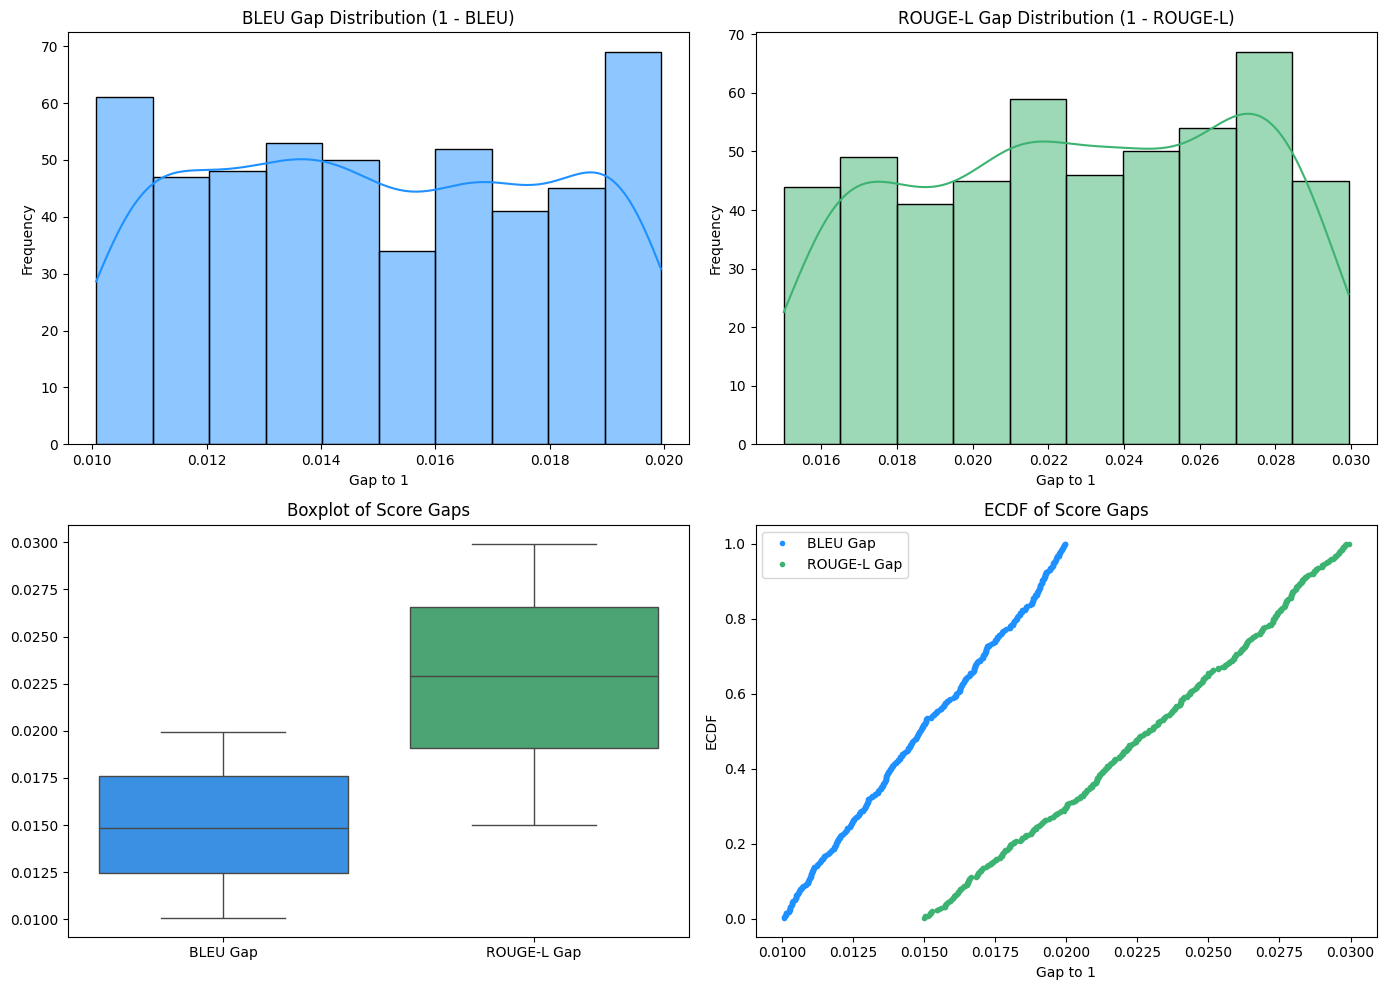

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_score_gaps(bleu_scores, rouge_scores):
    """
    Given lists of BLEU and ROUGE-L scores (each nearly 1) for 500 samples,
    this function computes the gap to 1 (i.e. 1 - score) for each metric and visualizes:
      - Histograms (with KDE) to show the distribution of gaps.
      - Boxplots for a quick summary of the gap statistics.
      - An ECDF plot to highlight the cumulative distribution of gaps.
      
    Parameters:
      bleu_scores (list or np.array): BLEU scores (each between 0 and 1).
      rouge_scores (list or np.array): ROUGE-L scores (each between 0 and 1).
    """
    # Convert scores to numpy arrays and compute the gap to 1
    bleu_gap = 1 - np.array(bleu_scores)
    rouge_gap = 1 - np.array(rouge_scores)
    
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histogram for BLEU gap
    sns.histplot(bleu_gap, kde=True, ax=axs[0,0], color='dodgerblue')
    axs[0,0].set_title("BLEU Gap Distribution (1 - BLEU)")
    axs[0,0].set_xlabel("Gap to 1")
    axs[0,0].set_ylabel("Frequency")
    
    # Histogram for ROUGE-L gap
    sns.histplot(rouge_gap, kde=True, ax=axs[0,1], color='mediumseagreen')
    axs[0,1].set_title("ROUGE-L Gap Distribution (1 - ROUGE-L)")
    axs[0,1].set_xlabel("Gap to 1")
    axs[0,1].set_ylabel("Frequency")
    
    # Boxplot for both gaps
    sns.boxplot(data=[bleu_gap, rouge_gap], ax=axs[1,0], palette=["dodgerblue", "mediumseagreen"])
    axs[1,0].set_xticklabels(["BLEU Gap", "ROUGE-L Gap"])
    axs[1,0].set_title("Boxplot of Score Gaps")
    
    # ECDF Plot: plot the cumulative distribution of the gaps
    for gap, label, color in zip([bleu_gap, rouge_gap], ["BLEU Gap", "ROUGE-L Gap"], ["dodgerblue", "mediumseagreen"]):
        sorted_gap = np.sort(gap)
        ecdf = np.arange(1, len(sorted_gap)+1) / len(sorted_gap)
        axs[1,1].plot(sorted_gap, ecdf, marker='.', linestyle='none', color=color, label=label)
    axs[1,1].set_title("ECDF of Score Gaps")
    axs[1,1].set_xlabel("Gap to 1")
    axs[1,1].set_ylabel("ECDF")
    axs[1,1].legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume bleu_scores and rouge_scores are lists of 500 float values each (close to 1).
# For illustration, we simulate some scores:
np.random.seed(42)
bleu_scores = 0.98 + 0.01 * np.random.rand(500)  # simulated scores between 0.98 and 0.99
rouge_scores = 0.97 + 0.015 * np.random.rand(500)  # simulated scores between 0.97 and 0.985

plot_score_gaps(bleu_scores, rouge_scores)


In [2]:
from utils import misc
loaded_data = misc.load_json_files(f"output/continue_generation")

In [26]:
from collections import defaultdict
import numpy as np

# def get_bleu_roughl(loaded_data):
bleu = []
rough_l = []
for schema in loaded_data:
    for layer in schema:
        for sample in layer:
            bleu.append(sample['bleu_rougel'][0][0])
            rough_l.append(sample['bleu_rougel'][0][1])


/tmp/ipykernel_213924/3891753731.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(["BLEU Gap", "ROUGE-L Gap"])


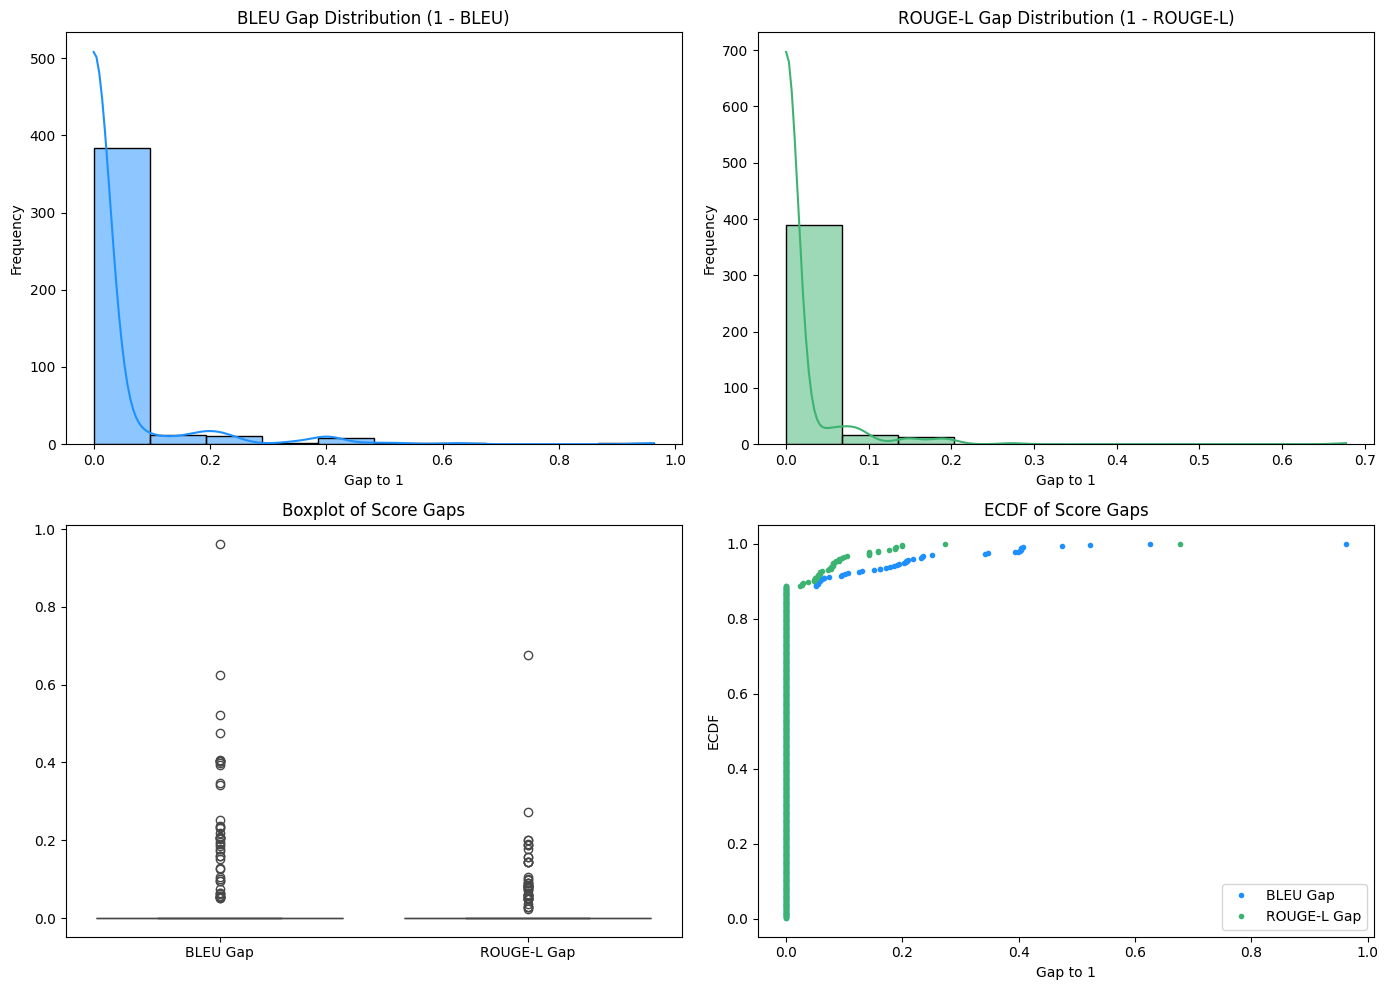

In [28]:
plot_score_gaps(bleu, rough_l)

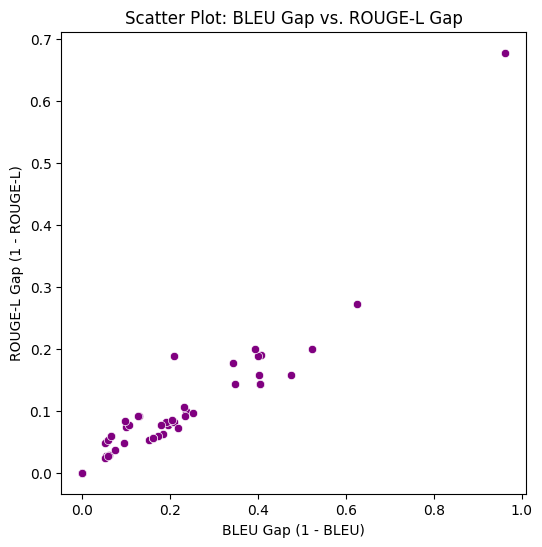

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_bleu_rouge_gaps(bleu_scores, rouge_scores):
    """
    Plot a scatter plot of BLEU gap vs. ROUGE-L gap.
    Each point represents one sample.
    """
    bleu_gap = 1 - np.array(bleu_scores)
    rouge_gap = 1 - np.array(rouge_scores)
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=bleu_gap, y=rouge_gap, color="purple")
    plt.title("Scatter Plot: BLEU Gap vs. ROUGE-L Gap")
    plt.xlabel("BLEU Gap (1 - BLEU)")
    plt.ylabel("ROUGE-L Gap (1 - ROUGE-L)")
    plt.show()

scatter_bleu_rouge_gaps(bleu, rough_l)

mean_bleu: 0.9738478736711002
mean_rouge: 0.9875805588866788


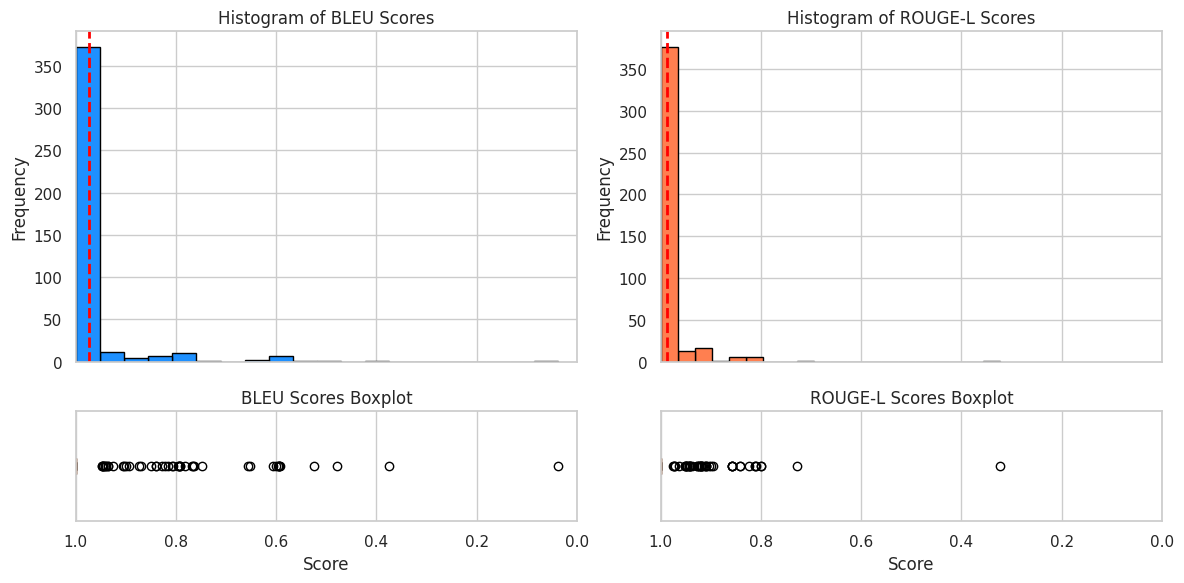

In [61]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_hist_and_box(bleu_scores, rouge_scores, bins=20):
    """
    Plots two columns:
      - Left column: BLEU histogram on top, BLEU boxplot on bottom.
      - Right column: ROUGE-L histogram on top, ROUGE-L boxplot on bottom.
    
    The x-axis represents the raw score (reversed from 1 to 0) and two trendy colors are used:
      - BLEU: dodgerblue
      - ROUGE-L: coral
    
    Parameters:
      bleu_scores (array-like): List or array of BLEU scores.
      rouge_scores (array-like): List or array of ROUGE-L scores.
      bins (int): Number of bins for the histograms.
    """
    # Create a 2x2 grid with custom height ratios (histogram taller than boxplot)
    fig, axes = plt.subplots(
        2, 2,
        figsize=(12, 6),
        gridspec_kw={'height_ratios': [3, 1]},
        sharex='col'
    )
    
    # --- Column 1: BLEU Scores ---
    # Top: Histogram
    axes[0, 0].hist(bleu_scores, bins=bins, color='dodgerblue', edgecolor='black')
    axes[0, 0].set_title("Histogram of BLEU Scores")
    axes[0, 0].set_ylabel("Frequency")
    
    # Compute and annotate the mean value for BLEU scores
    mean_bleu = np.mean(bleu_scores)
    print('mean_bleu:', mean_bleu)
    axes[0, 0].axvline(mean_bleu, color='red', linestyle='dashed', linewidth=2)

    # Bottom: Boxplot
    axes[1, 0].boxplot(bleu_scores, vert=False, patch_artist=True,
                       boxprops=dict(facecolor='dodgerblue', color='black'))
    axes[1, 0].set_title("BLEU Scores Boxplot")
    axes[1, 0].set_yticks([])  # Remove y-axis ticks for a cleaner look
    axes[1, 0].set_xlabel("Score")
    
    # --- Column 2: ROUGE-L Scores ---
    # Top: Histogram
    axes[0, 1].hist(rouge_scores, bins=bins, color='coral', edgecolor='black')
    axes[0, 1].set_title("Histogram of ROUGE-L Scores")
    axes[0, 1].set_ylabel("Frequency")

    # Compute and annotate the mean value for ROUGE-L scores
    mean_rouge = np.mean(rouge_scores)
    print('mean_rouge:', mean_rouge)
    axes[0, 1].axvline(mean_rouge, color='red', linestyle='dashed', linewidth=2)
    
    # Bottom: Boxplot
    axes[1, 1].boxplot(rouge_scores, vert=False, patch_artist=True,
                       boxprops=dict(facecolor='coral', color='black'))
    axes[1, 1].set_title("ROUGE-L Scores Boxplot")
    axes[1, 1].set_yticks([])
    axes[1, 1].set_xlabel("Score")
    
    # Reverse x-axis so that scores are shown from 1 to 0.
    for ax in axes.flat:
        ax.set_xlim(1, 0)
    
    plt.tight_layout()
    plt.show()

plot_hist_and_box(bleu, rough_l)

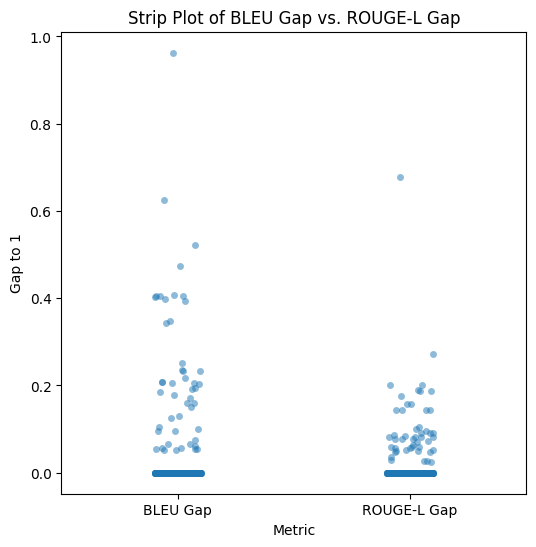

In [36]:
def hist_log_scale(bleu_scores, rouge_scores):
    bleu_gap = 1 - np.array(bleu_scores)
    rouge_gap = 1 - np.array(rouge_scores)
    plt.figure(figsize=(8, 4))
    # Add a small epsilon to avoid log(0)
    epsilon = 1e-6
    bleu_gap_log = np.log10(np.array(bleu_gap) + epsilon)
    rouge_gap_log = np.log10(np.array(rouge_gap) + epsilon)
    
    sns.histplot(bleu_gap_log, color="blue", alpha=0.6, label="BLEU Gap (log)")
    sns.histplot(rouge_gap_log, color="green", alpha=0.6, label="ROUGE-L Gap (log)")
    plt.xlabel("log10(Gap + 1e-6)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Gaps in Log Scale")
    plt.legend()
    plt.show()

def strip_plot_gaps(bleu_scores, rouge_scores):
    bleu_gap = 1 - np.array(bleu_scores)
    rouge_gap = 1 - np.array(rouge_scores)
    data = [
        *(("BLEU Gap", val) for val in bleu_gap),
        *(("ROUGE-L Gap", val) for val in rouge_gap),
    ]
    labels, values = zip(*data)
    
    plt.figure(figsize=(6, 6))
    sns.stripplot(x=labels, y=values, alpha=0.5)
    plt.title("Strip Plot of BLEU Gap vs. ROUGE-L Gap")
    plt.xlabel("Metric")
    plt.ylabel("Gap to 1")
    plt.show()


strip_plot_gaps(bleu, rough_l)


# Plot on Turning Points

In [23]:
from utils.misc import get_top_k, get_acc
from utils.n_grams import detect_ngram_copy

def ngram_char_edits(model, skip_up_to, edited_phrases, schema, n=5, k=100):
    # print("n-gram: ", n)
    # print("Skip layers: ", skip_up_to)

    return_scores = [] 
    total_patched_words = 20
    total_solvable_dict = {
        'swap': 0,
        'drop': 0,
        'add': 0
    }

    for edited in edited_phrases:
        if total_solvable_dict['swap'] == 3 and \
            total_solvable_dict['drop'] == 3 and \
                total_solvable_dict['add'] == 4:
            break
        
        return_outputs = schema(text = edited, model = model)
        if not return_outputs:
            continue

        # preprocess text
        for method, outputs in return_outputs.items():
            if total_solvable_dict[method] == 3 and method in ['swap', 'drop']:
                continue
            if total_solvable_dict[method] == 4 and method in ['add']:
                continue
            corrupted_sentence, decoded_up_to, ground_truth_next = outputs
            prompt = f"Please fix grammar of the following text: '{corrupted_sentence}'. The correct text is: {decoded_up_to}"
            prompt_tokens = model.to_tokens(prompt, prepend_bos=False)

            # run on the prompt once with cache to store activations to patch in later
            og_logits, og_cache = model.run_with_cache(prompt_tokens)
            # get the top k tokens
            og_topk_indices = get_top_k(og_logits, k)
            # get the highest prob token
            og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

            # check if model can solve the task
            decoded_og_next_token = model.to_string(og_next_token)[0]
            if ground_truth_next in decoded_og_next_token: 
                total_solvable_dict[method] += 1
            else:
                # total_unsolvable += 1
                continue

            patching_succeed_flag = True
            score_list_dict = {
                'acc2': [],
                'acc3': [],
                'jcc': []
            }       
            # start on patching model
            for num_word2patch in range(1, total_patched_words+1):
                if not patching_succeed_flag:
                    break

                dict_pred_info = defaultdict(dict)

                pos_matched = []
                pos_current = []
                total_matches = []

                for id in range(num_word2patch):
                    assert id < len(prompt_tokens[0])
                    pos_matched.append(detect_ngram_copy(prompt_tokens[:, :len(prompt_tokens[0])-id], n=n)[0])
                    pos_current.append(len(prompt_tokens[0])-id-1)

                # if there any none of finding ngram, break the experiment with current prompt
                # as it does not have enough tokens
                if None in pos_matched:
                    total_solvable_dict[method] -= 1
                    patching_succeed_flag = False
                    break            
                    
                # start hooking
                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    pos_matched: list,
                    pos_current: list
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, pos_current, :] = clean_resid_pre[:, pos_matched, :]
                    return resid_pre
                
                # Use functools.partial to create a temporary hook function with the position fixed
                temp_hook_fn = partial(residual_stream_patching_hook, pos_matched=pos_matched, pos_current=pos_current)
                # Run the model with the patching hook
                patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                    (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                ])
            
                pt_topk_indices = get_top_k(patched_logits, k)
                # get the highest prob token
                pt_next_token = torch.tensor([pt_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                # compare the predicted to the og prediction
                if torch.equal(og_next_token, pt_next_token):
                    total_matches.append(1)
                else:
                    total_matches.append(0)

                dict_pred_info[0]['original'] = og_topk_indices
                dict_pred_info[0]['copy'] = get_top_k(patched_logits, k)
            
                jcc, acc = get_acc([dict_pred_info])
                score_list_dict["acc2"].append(acc)
                score_list_dict["jcc"].append(jcc)
                score_list_dict["acc3"].append(sum(total_matches) / len(total_matches))

            if patching_succeed_flag:
                return_scores.append(score_list_dict)
    
    return return_scores

In [24]:
from tqdm import tqdm
task_name = 'turning_points'
info_lst = defaultdict(list)
for schema_name, schema in schemas.items():
    print(schema_name)
    for skip in tqdm(range(num_layers-1)):
        skip += 1
        if schema_name == 'char_edit':
            outputs = ngram_char_edits(model= model,
                                            skip_up_to= skip,
                                            edited_phrases= edited_phrases,
                                            schema= schema)
        else:
            outputs = n_grams.ngram(model= model,
                            skip_up_to= skip,
                            edited_phrases= edited_phrases,
                            schema= schema)
        info_lst[schema_name].append(outputs)

    misc.save_dict_to_json(info_lst[schema_name], f"output/{task_name}_{schema_name}.json")

char_edit


  3%|▎         | 1/35 [00:15<08:57, 15.80s/it]


KeyboardInterrupt: 

In [4]:
len(loaded_data)

35

In [5]:
import numpy as np

def aggregate_scores(list_of_data, score_types=['acc2', 'acc3', 'jcc']):
    """
    Given a list (e.g., 5 elements) where each element is a list of layers.
    Each layer is a list of dictionaries (e.g., 4 objects) and each dictionary 
    has keys (e.g., "acc2", "acc3", "jcc") mapping to a list of scores of length 2,
    this function computes, for each score type, a final 3x2 array of mean values.
    
    The mean is computed across all dictionaries in a layer and across all data elements.
    
    Returns:
        A dictionary mapping each score type to a numpy array of shape (num_layers, num_items)
        with the aggregated means.
    """
    # Assume all data elements have the same shape.
    num_layers = len(list_of_data[0])       # e.g., 3 layers
    # We assume that each dictionary's value is a list of length 2.
    num_items = len(list_of_data[0][0][0][score_types[0]])
    
    final_means = {score: np.zeros((num_layers, num_items)) for score in score_types}
    
    # For each score type, each layer, and each item, average over all dictionaries in that layer across all data.
    for score in score_types:
        for layer_idx in range(num_layers):
            # Collect all scores from all dictionaries in this layer across every data element.
            values = []
            for data in list_of_data:
                layer = data[layer_idx]  # a list of dictionaries for this layer
                for d in layer:
                    # d[score] is a list of length num_items; take the item at index item_idx.
                    values.append(d[score])
            # Now, values is a list of lists (each inner list of length num_items) coming from
            # (num_data_elements * num_objects) dictionaries.
            # Convert to numpy array and compute mean over axis 0.
            values = np.array(values)  # shape (n_total, num_items)
            mean_by_item = np.mean(values, axis=0)  # shape (num_items,)
            final_means[score][layer_idx, :] = mean_by_item
    
    return final_means

In [19]:
example_data

[[[{'acc2': [0.0185167439634234, 0.7889648458267519],
    'acc3': [0.14770025051385216, 0.3628712158693871],
    'jcc': [0.40011603979653887, 0.43343778726769866]},
   {'acc2': [0.39006722657322634, 0.5713049848272731],
    'acc3': [0.9806208379000652, 0.903781304008358],
    'jcc': [0.265497135136342, 0.5825528504466664]},
   {'acc2': [0.7280770539322546, 0.3008948996445111],
    'acc3': [0.03849067749352464, 0.7858952792450925],
    'jcc': [0.6164667186200322, 0.3755569972971602]},
   {'acc2': [0.9633790644514657, 0.002015558662517347],
    'acc3': [0.7713922509897959, 0.7176238586554584],
    'jcc': [0.3515974060289079, 0.11697598839723367]}]],
 [[{'acc2': [0.7499325666839635, 0.2822382301500794],
    'acc3': [0.5912258367447413, 0.811712469105803],
    'jcc': [0.05297560125179002, 0.7303536459206553]},
   {'acc2': [0.057520780885152334, 0.013709462250157012],
    'acc3': [0.7073995783959233, 0.7290505766555685],
    'jcc': [0.8157829254292928, 0.04183502044301102]},
   {'acc2': [0.

In [18]:
example_data = []
for _ in range(2):  # 5 data structures
    layers = []
    for _ in range(1):  # 2 layers
        layer = []
        for _ in range(4):  # 2 dictionaries per layer
            d = {
                "acc2": np.random.rand(2).tolist(),  # two scores
                "acc3": np.random.rand(2).tolist(),
                "jcc":  np.random.rand(2).tolist()
            }
            layer.append(d)
        layers.append(layer)
    example_data.append(layers)

final = aggregate_scores(example_data, score_types=['acc2', 'acc3', 'jcc'])
for score, matrix in final.items():
    print(f"{score}:")
    print(matrix)

acc2:
[[0.51484684 0.3705909 ]]
acc3:
[[0.48382586 0.59960769]]
jcc:
[[0.50745817 0.448386  ]]


In [90]:
def elementwise_mean(matrices):
    # Stack the matrices along a new axis, then compute the mean along that axis.
    matrices = np.array(matrices)
    stacked = np.stack(matrices)
    return np.mean(stacked, axis=0)
elementwise_mean([[1,2],
                  [2,3]])

array([1.5, 2.5])

In [147]:
import numpy as np
def elementwise_mean(matrices):
    # Stack the matrices along a new axis, then compute the mean along that axis.
    matrices = np.array(matrices)
    stacked = np.stack(matrices)
    return np.mean(stacked, axis=0)

def del_all_0(lst):
    _lst = [0]*len(lst)
    return lst==_lst

def get_mat_cg(data_lst, score_types, tokens=20):        
    # Compute the mean matrix for each score type
    matrices = {}
    for score in score_types:
        score_ult = []
        for data in data_lst:
            score_data = []
            for layer in data:
                # values = [d[score][0][0] for d in layer if not del_all_0(d[score][0][0])]
                values = [d[score][0][0] for d in layer]
                score_data.append(elementwise_mean(values))
            score_ult.append(score_data)
        matrices[score] = elementwise_mean(score_ult)[0]
        matrices[f'{score}_template'] = score_ult
    return matrices

data = get_mat_cg(loaded_data, score_types=['jcc_all', 'acc_all'])

In [148]:
def plot_hist_and_box(bleu_scores, rouge_scores, bins=10):
    """
    Plots two columns:
      - Left column: BLEU histogram on top, BLEU boxplot on bottom.
      - Right column: ROUGE-L histogram on top, ROUGE-L boxplot on bottom.
    
    The x-axis represents the raw score (reversed from 1 to 0) and two trendy colors are used:
      - BLEU: dodgerblue
      - ROUGE-L: coral
    
    Parameters:
      bleu_scores (array-like): List or array of BLEU scores.
      rouge_scores (array-like): List or array of ROUGE-L scores.
      bins (int): Number of bins for the histograms.
    """
    # Create a 2x2 grid with custom height ratios (histogram taller than boxplot)
    fig, axes = plt.subplots(
        2, 2,
        figsize=(12, 6),
        gridspec_kw={'height_ratios': [3, 1]},
        sharex='col'
    )
    
    # --- Column 1: BLEU Scores ---
    # Top: Histogram
    axes[0, 0].hist(bleu_scores, bins=bins, color='dodgerblue', edgecolor='black')
    axes[0, 0].set_title("Histogram of BLEU Scores")
    axes[0, 0].set_ylabel("Frequency")
    
    # Compute and annotate the mean value for BLEU scores
    mean_bleu = np.mean(bleu_scores)
    axes[0, 0].axvline(mean_bleu, color='red', linestyle='dashed', linewidth=2)

    # Bottom: Boxplot
    axes[1, 0].boxplot(bleu_scores, vert=False, patch_artist=True,
                       boxprops=dict(facecolor='dodgerblue', color='black'))
    axes[1, 0].set_title("BLEU Scores Boxplot")
    axes[1, 0].set_yticks([])  # Remove y-axis ticks for a cleaner look
    axes[1, 0].set_xlabel("Score")
    
    # --- Column 2: ROUGE-L Scores ---
    # Top: Histogram
    axes[0, 1].hist(rouge_scores, bins=bins, color='coral', edgecolor='black')
    axes[0, 1].set_title("Histogram of ROUGE-L Scores")
    axes[0, 1].set_ylabel("Frequency")

    # Compute and annotate the mean value for ROUGE-L scores
    mean_rouge = np.mean(rouge_scores)
    axes[0, 1].axvline(mean_rouge, color='red', linestyle='dashed', linewidth=2)
    
    # Bottom: Boxplot
    axes[1, 1].boxplot(rouge_scores, vert=False, patch_artist=True,
                       boxprops=dict(facecolor='coral', color='black'))
    axes[1, 1].set_title("ROUGE-L Scores Boxplot")
    axes[1, 1].set_yticks([])
    axes[1, 1].set_xlabel("Score")
    
    # Reverse x-axis so that scores are shown from 1 to 0.
    for ax in axes.flat:
        ax.set_xlim(1, 0)
    
    plt.tight_layout()
    plt.show()

{'jcc_all': array([0.90671605, 0.90677765, 0.90372069, 0.90308286, 0.89333932,
        0.89219716, 0.88990893, 0.89149803, 0.89285766, 0.89499954,
        0.89079229, 0.89590942, 0.89287321, 0.88708383, 0.88272454,
        0.88595595, 0.89199545, 0.89348883, 0.89023842, 0.8940876 ,
        0.88413408]),
 'jcc_all_template': [[array([0.9042439 , 0.90052764, 0.90921684, 0.9143923 , 0.90565239,
          0.90512552, 0.89283131, 0.90851333, 0.89485868, 0.90443677,
          0.90035763, 0.90599488, 0.8964419 , 0.90536629, 0.89372452,
          0.90045306, 0.90627183, 0.89743887, 0.89980003, 0.89682229,
          0.89757066])],
  [array([0.915286  , 0.91847831, 0.93323253, 0.93190103, 0.92710945,
          0.92374612, 0.91339817, 0.92166444, 0.92099198, 0.92545142,
          0.92272899, 0.92021055, 0.92603086, 0.91324484, 0.91229974,
          0.92127467, 0.92169823, 0.91882612, 0.91791601, 0.91545223,
          0.91304795])],
  [array([0.89171897, 0.91395352, 0.86724583, 0.8681327 , 0.86024

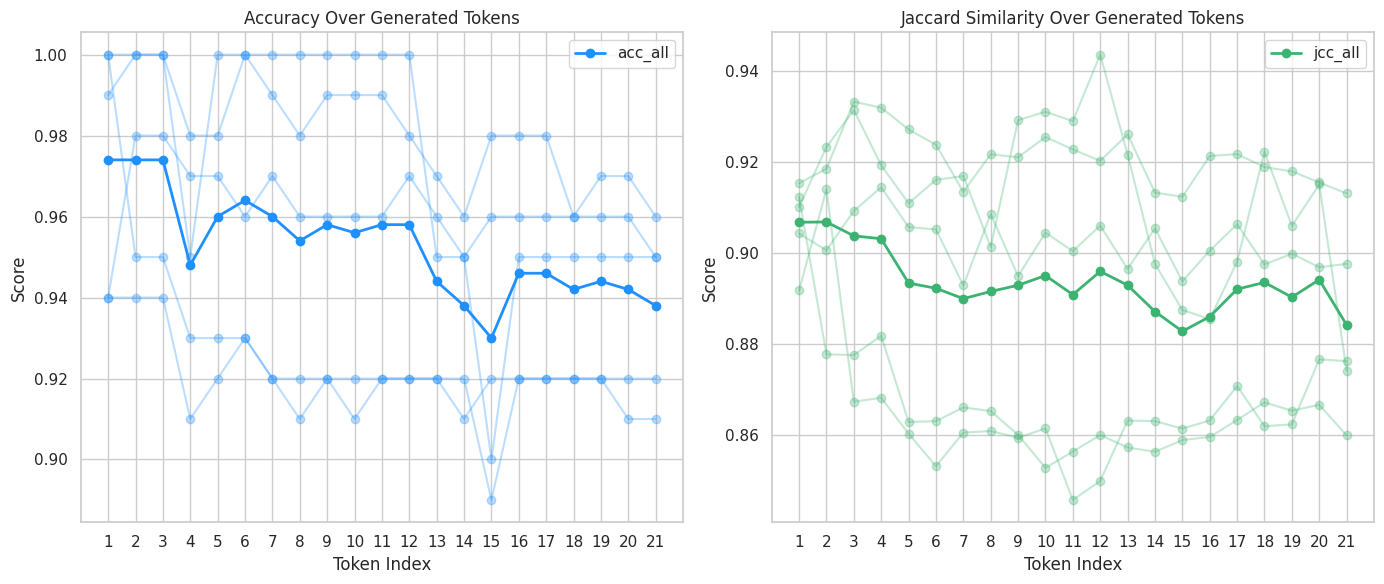

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_token_scores(data):
    """
    Given a data dictionary containing two metrics for continuous generation:
      - 'acc_all': a 1D numpy array (length n) representing the average acc scores.
      - 'acc_all_template': a list of lists (each with one numpy array of length n) 
          representing individual template acc scores.
      - 'jcc_all': a 1D numpy array (length n) representing the average jcc scores.
      - 'jcc_all_template': a list of lists (each with one numpy array of length n)
          representing individual template jcc scores.
          
    This function creates two subplots (one for each metric). In each subplot:
      - The main (average) line is plotted in a solid, prominent color.
      - Each template line is overlaid with the same color but with lower transparency.
      - The x-axis shows token indices from 1 to n.
      
    Parameters:
      data (dict): A dictionary with keys 'acc_all', 'acc_all_template', 'jcc_all', and 'jcc_all_template'.
    """
    # Determine the number of tokens from the average array (assumes acc_all and jcc_all have same length)
    n = len(data['acc_all'])
    tokens = np.arange(1, n + 1)
    
    # Set a trendy seaborn theme
    sns.set_theme(style="whitegrid")
    
    # Create subplots for the two metrics: ACC and JCC
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- Plot for ACC ---
    ax = axs[0]
    # Plot the main acc line
    ax.plot(tokens, data['acc_all'], label='acc_all', color='dodgerblue', marker='o', linewidth=2)
    # Plot each template in acc_all_template with lower transparency
    for template in data['acc_all_template']:
        # Each template is assumed to be a list with one array element.
        template_line = template[0]
        ax.plot(tokens, template_line, color='dodgerblue', marker='o', alpha=0.3)
    ax.set_xlabel("Token Index")
    ax.set_ylabel("Score")
    ax.set_title("Accuracy Over Generated Tokens")
    ax.legend()
    
    # --- Plot for JCC ---
    ax = axs[1]
    # Plot the main jcc line
    ax.plot(tokens, data['jcc_all'], label='jcc_all', color='mediumseagreen', marker='o', linewidth=2)
    # Plot each template in jcc_all_template with lower transparency
    for template in data['jcc_all_template']:
        template_line = template[0]
        ax.plot(tokens, template_line, color='mediumseagreen', marker='o', alpha=0.3)
    ax.set_xlabel("Token Index")
    ax.set_ylabel("Score")
    ax.set_title("Jaccard Similarity Over Generated Tokens")
    ax.legend()
    
    # Set x-axis ticks from 1 to n (integer labels)
    for ax in axs:
        ax.set_xticks(np.arange(1, n + 1))
        ax.set_xticklabels(np.arange(1, n + 1))
    
    plt.tight_layout()
    plt.show()


plot_token_scores(data)

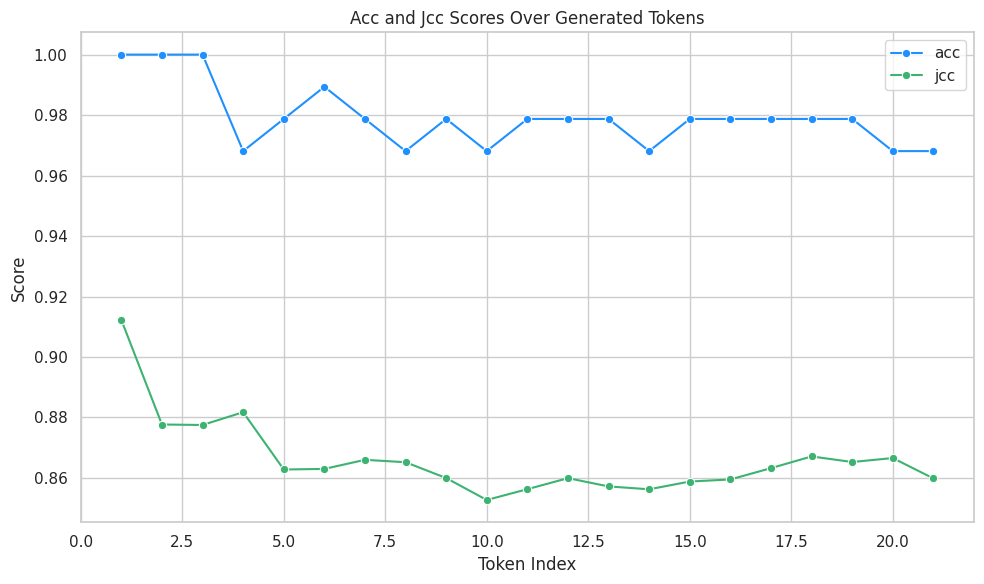

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_token_scores(acc_scores, jcc_scores):
    """
    Given two arrays (lists or numpy arrays) of scores for 'acc' and 'jcc'
    over n generated tokens, this function creates a line plot with token index
    on the x-axis and score on the y-axis. It uses seaborn for a nice, trendy style.
    
    Parameters:
        acc_scores (array-like): Scores for 'acc' (length n).
        jcc_scores (array-like): Scores for 'jcc' (length n).
    """
    n = len(acc_scores)
    tokens = np.arange(1, n + 1)
    
    # Set a nice, trendy theme
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Plot the two lines with distinct colors and markers.
    sns.lineplot(x=tokens, y=acc_scores, label="acc", marker="o", color="dodgerblue")
    sns.lineplot(x=tokens, y=jcc_scores, label="jcc", marker="o", color="mediumseagreen")
    
    plt.xlabel("Token Index")
    plt.ylabel("Score")
    plt.title("Acc and Jcc Scores Over Generated Tokens")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_token_scores(acc['acc_all'], jcc['jcc_all'])

In [120]:
from utils import misc
task_name = 'continue_generation'
# loaded_data = misc.load_dict_from_json(f"output/copy_mode/copy_mode_swap_a_the.json")
loaded_data = misc.load_json_files(f"output/continue_generation")

In [1]:
# load model and tokenizer
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained("Qwen/Qwen2.5-3B")
num_layers = model.cfg.n_layers
# tokenizer = Qwen2Tokenizer.from_pretrained("Qwen/Qwen2.5-3B")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen2.5-3B into HookedTransformer


In [1]:
d_head = 128
d_mlp = 11008
d_model = 2048
n_ctx = 2048
n_heads = 16
n_layers = 36
n_params = 3038773248


In [8]:
model.cfg

HookedTransformerConfig:
{'NTK_by_parts_factor': 8.0,
 'NTK_by_parts_high_freq_factor': 4.0,
 'NTK_by_parts_low_freq_factor': 1.0,
 'act_fn': 'silu',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 11.313708498984761,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 128,
 'd_mlp': 11008,
 'd_model': 2048,
 'd_vocab': 151936,
 'd_vocab_out': 151936,
 'decoder_start_token_id': None,
 'default_prepend_bos': False,
 'device': device(type='cuda'),
 'dtype': torch.float32,
 'eps': 1e-06,
 'experts_per_token': None,
 'final_rms': True,
 'from_checkpoint': False,
 'gated_mlp': True,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02,
 'load_in_4bit': False,
 'model_name': 'Qwen2.5-3B',
 'n_ctx': 2048,
 'n_devices': 1,
 'n_heads': 16,
 'n_key_value_heads': 2,
 'n_layers': 36,
 'n_params': 3038773248,
 'normalization_type': 'RMSPre',
 'num_experts': None,
 'or

In [1]:
def print_flops_reduction_table(total_layers, patched_layer, cost_per_layer, pp=None, tt=None):
    """
    Prints an illustrative table of per-token FLOPs in a decoder model for unpatched and patched decoding.
    
    In normal decoding, every token performs a full forward pass through all layers.
    With patching, for tokens where we reuse a previously computed residual (starting at a given layer),
    the forward computations (e.g. multi-head attention, MLP, layernorm) in those layers are skipped.
    
    Parameters:
      total_layers (int): Total number of layers in the model.
      patched_layer (int): The 1-indexed layer from which patching is applied.
                           For layers >= patched_layer, the forward cost is assumed ≈0.
      cost_per_layer (float): Estimated FLOPs per token for one layer (assumed uniform across layers).
                              (For example, 1e12 for illustration.)
      pp (int, optional): Number of patched layers (if not provided, computed as total_layers - patched_layer + 1).
      tt (int, optional): Number of tokens that are patched. If provided, overall savings are estimated.
    
    The function prints a table with columns:
      Layer | FLOPs per token (Unpatched) | FLOPs per token (Patched)
    
    It then prints an optional estimate of per-token savings and total savings if pp layers are patched for tt tokens.
    """
    print("Quantifying Efficiency: Theoretical FLOP Reduction")
    print("\nFLOPs (floating point operations) are a standard proxy for model compute cost.")
    print("In normal decoding, every token involves a full forward pass through all layers.")
    print("With patching, for certain tokens, instead of recomputing activations at deep layers,")
    print("we simply copy the pre-computed residual stream from a previous position.")
    print("This skips the multi-head attention, MLP block, and layernorms in each patched layer.\n")
    
    header = f"{'Layer':<10}{'FLOPs per token (Unpatched)':<35}{'FLOPs per token (Patched)':<35}"
    print(header)
    print("-" * len(header))
    
    for layer in range(1, total_layers+1):
        unpatched = cost_per_layer  # each layer is computed fully in unpatched case
        if layer < patched_layer:
            patched = cost_per_layer  # before patching starts, same cost
        else:
            patched = 0.0            # after patching, cost is near zero (reuse only)
        print(f"{layer:<10}{unpatched:<35.2e}{patched:<35.2e}")
    
    # Optional estimate of savings
    if pp is None:
        pp = total_layers - patched_layer + 1  # number of layers that are patched
    if tt is not None:
        savings_per_token = pp * cost_per_layer
        total_savings = tt * savings_per_token
        print("\nEstimated Savings:")
        print(f"  For {pp} patched layers, each patched token saves ≈ {savings_per_token:.2e} FLOPs.")
        print(f"  For {tt} patched tokens, total savings ≈ {total_savings:.2e} FLOPs.")
    else:
        print(f"\nEach patched token saves ≈ {pp * cost_per_layer:.2e} FLOPs compared to unpatched decoding.")

# Example usage:
# Assume a model with 24 layers, and we start patching at layer 18.
# For illustration, suppose each layer costs 1e12 FLOPs per token.
total_layers = 24
patched_layer = 18
cost_per_layer = 1e12

# Optionally, if patching is applied to pp layers for tt tokens:
pp = total_layers - patched_layer + 1  # here, 24 - 18 + 1 = 7 patched layers
tt = 1000  # say, 1000 tokens are patched

print_flops_reduction_table(total_layers, patched_layer, cost_per_layer, pp, tt)


Quantifying Efficiency: Theoretical FLOP Reduction

FLOPs (floating point operations) are a standard proxy for model compute cost.
In normal decoding, every token involves a full forward pass through all layers.
With patching, for certain tokens, instead of recomputing activations at deep layers,
we simply copy the pre-computed residual stream from a previous position.
This skips the multi-head attention, MLP block, and layernorms in each patched layer.

Layer     FLOPs per token (Unpatched)        FLOPs per token (Patched)          
--------------------------------------------------------------------------------
1         1.00e+12                           1.00e+12                           
2         1.00e+12                           1.00e+12                           
3         1.00e+12                           1.00e+12                           
4         1.00e+12                           1.00e+12                           
5         1.00e+12                           1.00e+12  

In [8]:
def calculate_patch_savings(total_layers, patched_layers, cost_per_layer, total_tokens, patched_tokens):
    """
    Calculate the theoretical FLOP reduction when patching is applied during inference.
    
    In normal inference, each token costs:
        cost_normal = total_layers * cost_per_layer.
    
    For tokens that are patched, we only compute the later layers:
        cost_patched = (total_layers - patched_layers) * cost_per_layer.
    
    Parameters:
      total_layers (int): Total number of layers in the model (L).
      patched_layers (int): Number of layers that are patched (l_p). For these layers, activations are reused.
      cost_per_layer (float): FLOPs cost per token per layer (C).
      total_tokens (int): Total number of tokens processed (N).
      patched_tokens (int): Number of tokens that are patched (N_p).
      
    Returns:
      reduction_ratio (float): Fraction of FLOPs saved relative to unpatched inference.
      flops_saved (float): Total FLOPs saved.
      total_flops_normal (float): Total FLOPs if no patching were used.
      total_flops_patched (float): Total FLOPs with patching applied.
    """
    # Cost per token for unpatched decoding
    cost_normal = total_layers * cost_per_layer
    # Cost per patched token (only compute layers after patched layers)
    cost_patched = (total_layers - patched_layers) * cost_per_layer
    
    # Total FLOPs without patching:
    total_flops_normal = total_tokens * cost_normal
    # Total FLOPs with patching:
    total_flops_patched = (total_tokens - patched_tokens) * cost_normal + patched_tokens * cost_patched
    
    # FLOPs saved:
    flops_saved = total_flops_normal - total_flops_patched
    # Reduction ratio:
    reduction_ratio = flops_saved / total_flops_normal
    
    return reduction_ratio, flops_saved, total_flops_normal, total_flops_patched

# Example usage:
# Suppose our model has 24 layers and cost_per_layer = 1e12 FLOPs per token per layer.
# The total sequence contains 1000 tokens.
# For a repeated segment, assume 300 tokens are patched (i.e. their first 5 layers are reused).
total_layers = n_layers
patched_layers = 5   # We patch the first 5 layers
cost_per_layer = 2.19e+08  # (example cost)
total_tokens = 100
patched_tokens = 20

reduction_ratio, flops_saved, total_normal, total_patched = calculate_patch_savings(
    total_layers, patched_layers, cost_per_layer, total_tokens, patched_tokens
)

print(f"Total FLOPs (Normal): {total_normal:.2e}")
print(f"Total FLOPs (Patched): {total_patched:.2e}")
print(f"FLOPs Saved: {flops_saved:.2e}")
print(f"Theoretical Inference Cost Reduction: {reduction_ratio*100:.2f}%")

Total FLOPs (Normal): 7.88e+11
Total FLOPs (Patched): 7.66e+11
FLOPs Saved: 2.19e+10
Theoretical Inference Cost Reduction: 2.78%


In [2]:
def compute_cost_per_layer(config):
    """
    Estimate the forward-pass FLOPs cost per token for a single Transformer layer.
    
    The total forward pass cost per token for a model is approximated as:
        flops_per_token_forward = 2*N + 12*L*H*Q*T,
    where:
      - N is the total number of parameters,
      - L is the number of layers,
      - H is the number of attention heads,
      - Q = n_embd // n_head is the head dimension,
      - T is the sequence length (block_size).
    
    We attribute the dense (feed-forward) cost evenly across layers:
        cost_ff_per_layer = 2*N / L,
    and assume each layer’s self-attention cost is:
        cost_sa_per_layer = 12 * H * Q * T.
    
    Thus, the per-layer cost (forward pass) is:
        cost_per_layer = (2*N / L) + (12 * H * Q * T).
    
    Parameters:
      config: An object with the following attributes:
          - n_layer (int): number of layers (L)
          - n_head (int): number of attention heads (H)
          - n_embd (int): model embedding dimension
          - block_size (int): sequence length (T)
          - get_num_params() or n_params: total number of parameters (N)
    
    Returns:
      float: Estimated FLOPs cost per token per layer for the forward pass.
    """
    # Retrieve total parameters. Use get_num_params() if available; otherwise, assume config.n_params.
    N = config.get_num_params() if callable(getattr(config, "get_num_params", None)) else config.n_params
    L = config.n_layer
    H = config.n_head
    Q = config.n_embd // config.n_head
    T = config.block_size
    
    # Feed-forward (dense) cost per layer (forward only): 2N distributed evenly across layers.
    cost_ff = 2 * N / L
    
    # Self-attention cost per layer (forward only)
    cost_sa = 12 * H * Q * T
    
    cost_per_layer = cost_ff + cost_sa
    return cost_per_layer

# Example usage:
# Suppose you have a config for a gwen2.5b model:
d_head = 128
d_mlp = 11008
d_model = 2048
n_ctx = 2048
n_heads = 16
n_layers = 36
n_params = 3038773248


class Config:
    n_layer = n_layers
    n_head = n_heads
    n_embd = d_model
    block_size = n_ctx
    n_params = n_params
    def get_num_params(self):
        return self.n_params

config = Config()
layer_cost = compute_cost_per_layer(config)
print(f"Estimated cost per layer (FLOPs per token): {layer_cost:.2e}")

Estimated cost per layer (FLOPs per token): 2.19e+08


In [4]:
def estimate_forward_mfu(config, dt, gpu_peak_flops=35.6e12):
    """
    Estimate the model FLOPs utilization (MFU) for only the forward pass,
    expressed as a ratio of the achieved throughput (FLOPs per second) relative
    to the theoretical peak throughput of a single NVIDIA RTX 3090.

    Parameters:
      config: An object or namespace with the following attributes:
              - n_layer: number of layers (L)
              - n_head: number of attention heads (H)
              - n_embd: embedding dimension (so that head dimension Q = n_embd // n_head)
              - block_size: sequence length (T)
              Additionally, config should allow retrieval of the total number of parameters (N)
              via a method get_num_params() or an attribute.
      dt (float): The time (in seconds) taken for one forward pass iteration (processing T tokens).
      gpu_peak_flops (float): The theoretical peak FLOPs of the GPU. Default is 35.6e12 for an RTX 3090 FP32.

    Returns:
      mfu (float): The estimated FLOPs utilization (a ratio between 0 and 1) for the forward pass.
    """
    # Total number of parameters.
    N = config.get_num_params() if callable(getattr(config, "get_num_params", None)) else config.n_params

    # Unpack model dimensions.
    L = config.n_layer
    H = config.n_head
    Q = config.n_embd // config.n_head
    T = config.block_size

    # Estimate forward-pass FLOPs per token:
    #   - 2N FLOPs for the dense (feed-forward) parts (forward-only cost, compared to 6N for full fwdbwd)
    #   - 12*L*H*Q*T FLOPs for self-attention.
    flops_per_token = 2 * N + 12 * L * H * Q * T

    # Total forward FLOPs for processing T tokens.
    flops_forward = flops_per_token * T

    # Achieved FLOPs throughput (per second).
    flops_achieved = flops_forward / dt

    # Compute MFU: the fraction of the GPU's theoretical peak used.
    mfu = flops_achieved / gpu_peak_flops
    return mfu

# Example usage:
# Suppose we have a config object for gwen2.5b with:
#   n_layer = 32, n_head = 32, n_embd = 2560, block_size = 1024,
# and assume a total parameter count of 2.5 billion (2.5e9). 
# (In practice, your config would provide these values.)

d_head = 128
d_mlp = 11008
d_model = 2048
n_ctx = 2048
n_heads = 16
n_layers = 36
n_params = 3038773248


class Config:
    n_layer = n_layers
    n_head = n_heads
    n_embd = d_model
    block_size = n_ctx
    n_params = n_params
    def get_num_params(self):
        return self.n_params

# Assume dt (time per forward iteration) is measured as 0.05 seconds.
config = Config()
dt = 0.05
mfu_forward = estimate_forward_mfu(config, dt)
print(f"Forward Pass MFU on RTX 3090: {mfu_forward*100:.2f}%")


Forward Pass MFU on RTX 3090: 345.55%


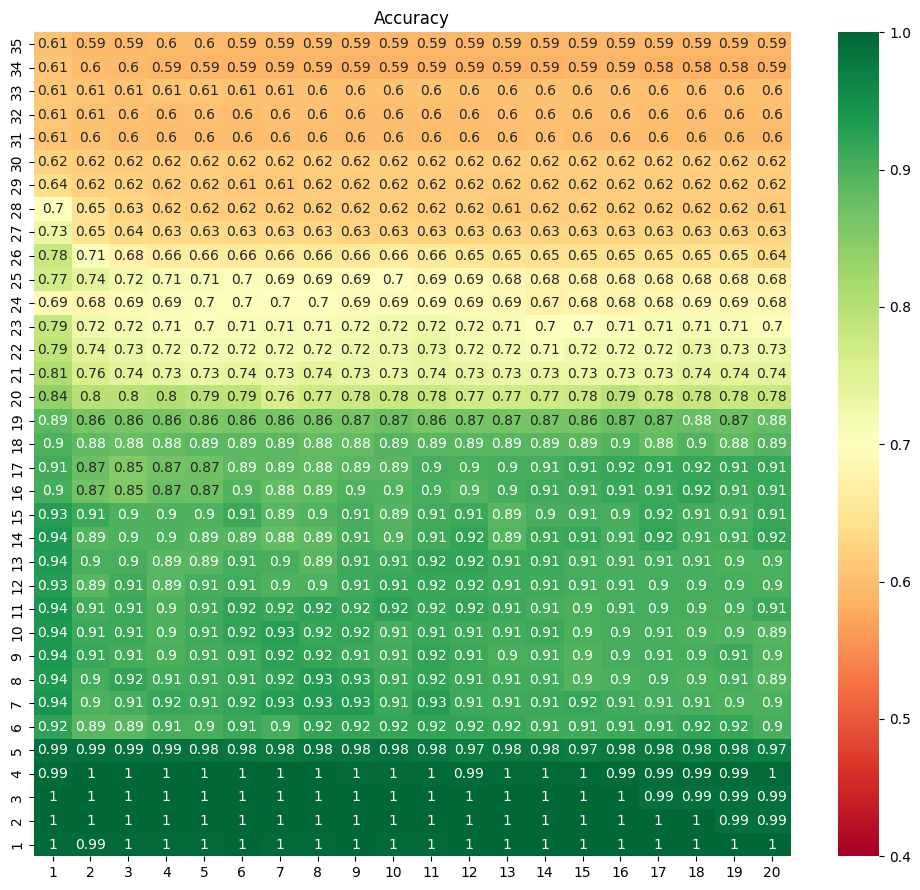

In [3]:
from utils import misc
task_name = 'turning_points'
# loaded_data = misc.load_dict_from_json(f"output/copy_mode/copy_mode_swap_a_the.json")
loaded_data = misc.load_json_files(f"output/turning_points")
misc.plot_score_heatmaps(loaded_data, score_types=['acc2'])

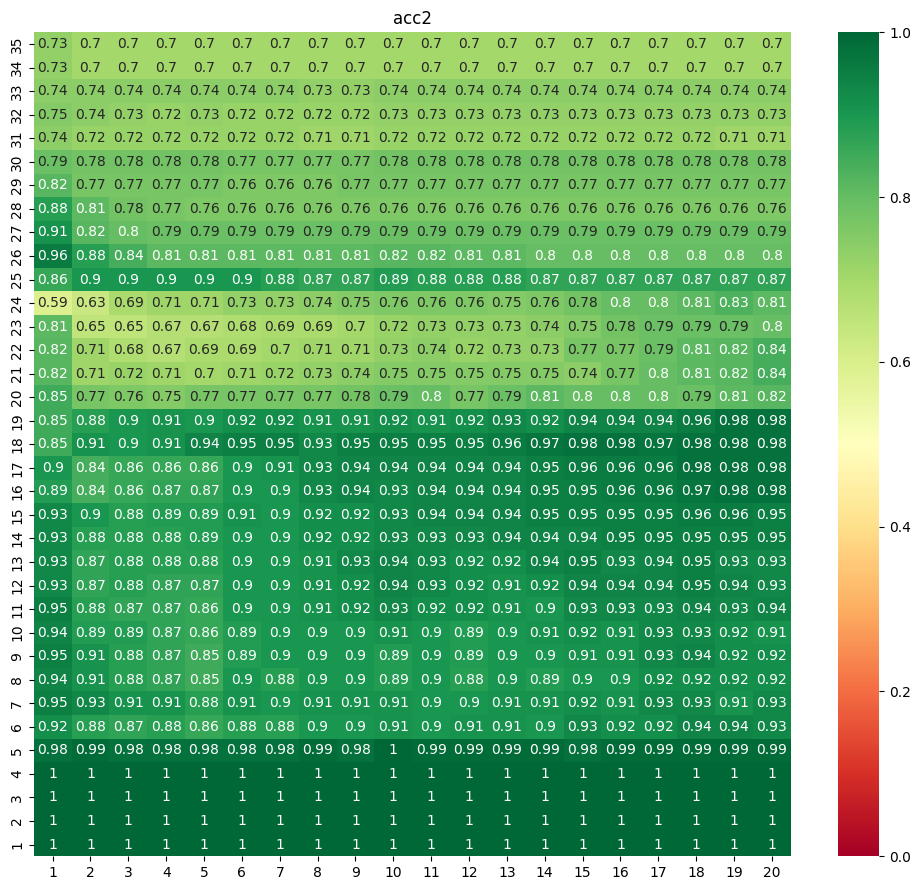

In [4]:
from utils import misc
task_name = 'turning_points'
loaded_data = misc.load_dict_from_json(f"output/turning_points_swap_was_were.json")
misc.plot_score_heatmaps(loaded_data, score_types=['acc2'])

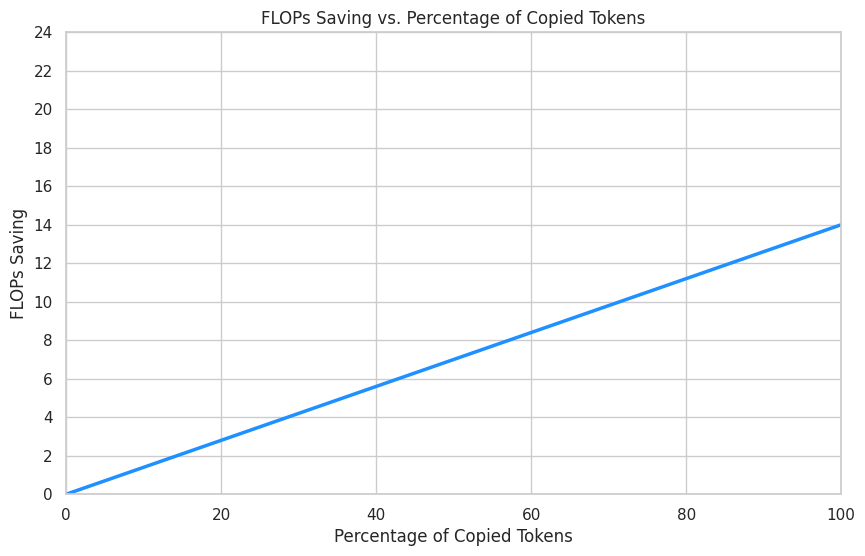

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_flops_saving():
    """
    Plots a line showing FLOPs saving as a function of the percentage of copied tokens.
    
    The x-axis spans from 0 to 100 (representing percentage of copied tokens),
    while the y-axis spans from 0 to 20 (representing FLOPs saving in percent).
    The line increases linearly such that at x=100, the FLOPs saving is 14%.
    """
    # Generate x values (percentage of copied tokens) from 0 to 100.
    x = np.linspace(0, 100, num=101)
    # Calculate y values for FLOPs saving: linearly increasing from 0 to 14%
    y = (14 / 100) * x  # y will be 14 when x is 100

    # Set Seaborn theme for a clean and modern look
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 7))
    
    # Plot the line using a nice blue color
    sns.lineplot(x=x, y=y, color='dodgerblue', linewidth=2.5)
    
    # Set axis limits as specified
    plt.xlim(0, 100)
    plt.ylim(0, 20)
    
    # Label the axes and provide a title
    plt.xlabel("Percentage of Copied Tokens (%)", fontsize=12)
    plt.ylabel("FLOPs Saving (%)", fontsize=12)
    plt.title("FLOPs Saving vs. Percentage of Copied Tokens", fontsize=14, fontweight='bold')
    
    # Display the plot
    plt.show()

# Example usage:
plot_flops_saving()


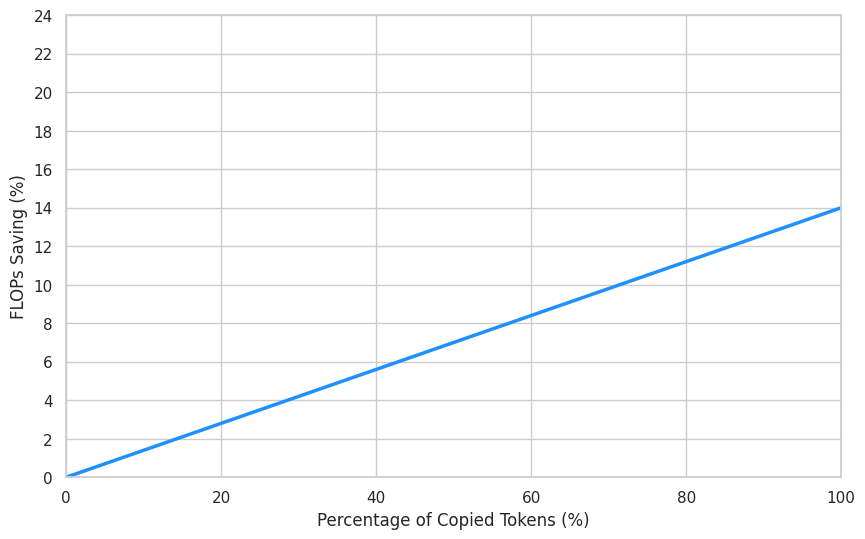

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_flops_saving_line():
    """
    Plots a line chart where:
      - x-axis: Percentage of copied tokens (0 to 100)
      - y-axis: FLOPs saving (0 to 24), with a line that goes from 0 to 14.
    The y-axis ticks have a step of 2.
    """
    # Set the theme using Seaborn for a modern appearance.
    sns.set_theme(style="whitegrid")
    
    # Generate x values: percentage of copied tokens from 0 to 100.
    x = np.linspace(0, 100, 101)
    
    # Define a linear relationship for FLOPs saving such that:
    # when x = 0, y = 0 and when x = 100, y = 14.
    y = (14 / 100) * x
    
    # Create the figure.
    plt.figure(figsize=(10, 6))
    
    # Plot the line using Seaborn's lineplot with the specified color.
    sns.lineplot(x=x, y=y, color="dodgerblue", linewidth=2.5)
    
    # Set the x-axis limits (0 to 100) and y-axis limits (0 to 24).
    plt.xlim(0, 100)
    plt.ylim(0, 24)
    
    # Set y-axis ticks in increments of 2.
    plt.yticks(np.arange(0, 25, 2))
    
    # Label the axes and provide a title.
    plt.xlabel("Percentage of Copied Tokens (%)", fontsize=12)
    plt.ylabel("FLOPs Saving (%)", fontsize=12)
    # plt.title("FLOPs Saving vs. Percentage of Copied Tokens", fontsize=14, fontweight='bold')
    
    # Display the plot.
    plt.show()

# Call the function to display the plot.
plot_flops_saving_line()


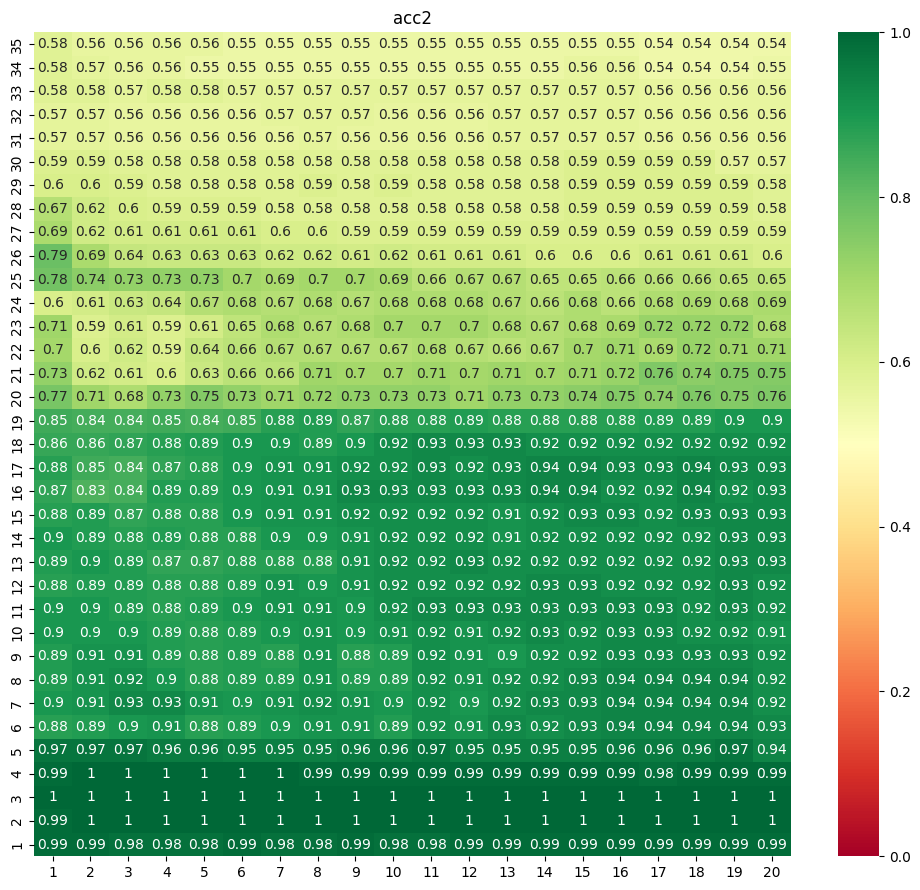

In [3]:
from utils import misc
task_name = 'turning_points'
loaded_data = misc.load_dict_from_json(f"output/turning_points_swap_is_are.json")
misc.plot_score_heatmaps(loaded_data, score_types=['acc2'])

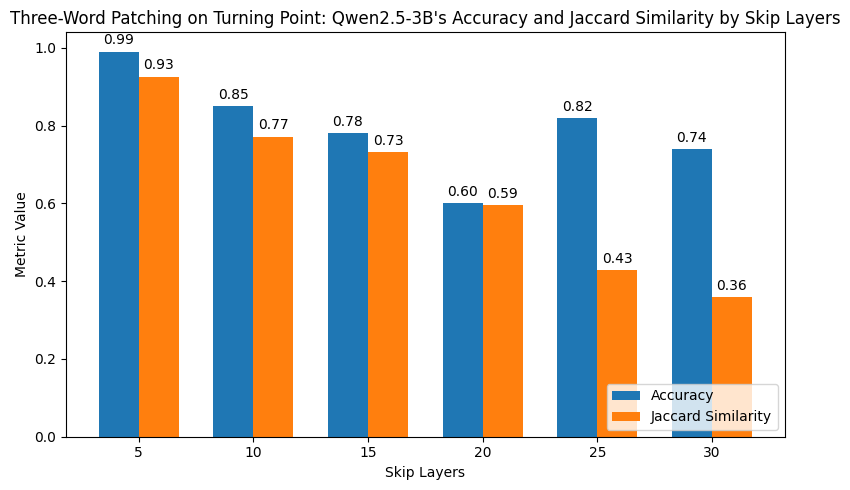

In [ ]:
skip_layers = skip_up_to

plot_skip_layer_metrics(skip_layers, acc, jcc, model_name="Qwen2.5-3B", schema="Three-Word Patching on Turning Point")

# Plot Not the Turning Points

In [8]:
def ngram(n, model, skip_up_to, max_steps, extra_steps, k, edited_phrases):

    print("n-gram: ", n)
    print("Skip layers: ", skip_up_to)

    info_lst = []
    # failed_lst = []

    total_failed_by_prepocess = 0
    # total_failed_as_ulsolvable = 0
    total_solvable_og = 0
    total_unsolvable = 0
    total_matches = []

    num_matched = 0
    # total_steps = 0

    for edited in tqdm(edited_phrases):

        if total_solvable_og == 100:
            break

        if not has_required_spaces(edited, num_context = 10):
            continue

        # preprocess text
        edited = text_preprocess(edited)
        if edited is None:
            total_failed_by_prepocess += 1
            continue

        corrupted_text, pre_isare, correct_tobe = edited
        prompt = f"Please fix grammar of the following text: '{corrupted_text}'. The correct text is: {pre_isare}"

        dict_pred_info = defaultdict(dict)

        steps = 1
        for step_i in range(steps):
            # print(prompt)

            if step_i != 0:
                # Prompt: A B C D is .... A B C D [are]
                prompt_tokens = model.to_tokens(prompt, prepend_bos=False)
            else:
                prompt_tokens = model.to_tokens(prompt)

            # print('og prompt: ', prompt_tokens)

            # As we does not need on the turning point, we can skip the last tokens
            # Prompt: A B C D is .... A B C [D]
            # Get the last token of the prompt as the token to predict
            next_token_ref = prompt_tokens[:, -1]
            prompt_tokens = prompt_tokens[:, :-1]      

            # run on the prompt once with cache to store activations to patch in later
            og_logits, og_cache = model.run_with_cache(prompt_tokens)
            # get the top k tokens
            og_topk_indices = get_top_k(og_logits, k)
            # get the highest prob token
            og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

            # # append the token to the sequence
            # prompt_tokens = torch.cat([prompt_tokens, og_next_token], dim=1)
            # print('generated: ', prompt_tokens)
            # # deocde the token
            # prompt = model.to_string(prompt_tokens)[0]
            # print('OG:', prompt)            

            # check if model can solve the task (now, D should be predicted, aka next_token_ref)
            if torch.equal(og_next_token[0], next_token_ref):
                total_solvable_og += 1
            else:
                total_unsolvable += 1
                continue

            # detect copy scenario
            # Prompt: A B C D is .... A B C [D]
            t_matched_1st, _ = detect_ngram_copy(prompt_tokens, n=n)
            t_matched_2nd, _ = detect_ngram_copy(prompt_tokens[:,:-1], n=n)
            t_matched_3nd, _ = detect_ngram_copy(prompt_tokens[:,:-2], n=n)
            
            if t_matched_1st is not None and t_matched_2nd and t_matched_3nd is not None:
                pos_matched = [t_matched_1st, t_matched_2nd, t_matched_3nd]
                pos_current = [len(prompt_tokens[0])-1, len(prompt_tokens[0])-2, len(prompt_tokens[0])-3]
                
                num_matched += 1

                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    pos_matched: list,
                    pos_current: list
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, pos_current, :] = clean_resid_pre[:, pos_matched, :]
                    return resid_pre
                
                # Use functools.partial to create a temporary hook function with the position fixed
                temp_hook_fn = partial(residual_stream_patching_hook, pos_matched=pos_matched, pos_current=pos_current)
                # Run the model with the patching hook
                patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                    (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                ])

                # def v_patching_hook(
                #     resid_pre: Float[torch.Tensor, "batch pos head_index d_head"],
                #     hook: HookPoint,
                #     position: int
                # ) -> Float[torch.Tensor, "batch pos head_index d_head"]:
                #     # Each HookPoint has a name attribute giving the name of the hook.
                #     clean_resid_pre = og_cache[hook.name]
                #     resid_pre[:, -1, :, :] = clean_resid_pre[:, position, :, :]
                #     return resid_pre
                
                # for layer in range(skip_up_to):
                #     # Use functools.partial to create a temporary hook function with the position fixed
                #     temp_hook_fn = partial(v_patching_hook, position=t_matched)
                #     # Run the model with the patching hook
                #     patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                #         (utils.get_act_name("v", layer), temp_hook_fn)
                #     ])
                
                pt_topk_indices = get_top_k(patched_logits, k)
                # get the highest prob token
                pt_next_token = torch.tensor([pt_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                # check if model can solve the task
                if torch.equal(next_token_ref, pt_next_token[0]):
                    total_matches.append(1)
                else:
                    total_matches.append(0)

                # # append the token to the sequence
                # pt_prompt_tokens = torch.cat([prompt_tokens, pt_next_token], dim=1)
                # # deocde the token
                # pt_prompt = model.to_string(pt_prompt_tokens)[0]      
                # print('PT:\n')
                # print(pt_prompt)

                dict_pred_info[step_i]['original'] = og_topk_indices
                dict_pred_info[step_i]['copy'] = get_top_k(patched_logits, k)
            else:
                # not enough context for cp
                total_solvable_og -= 1

            # # append the token to the sequence
            # prompt_tokens = torch.cat([prompt_tokens, og_next_token], dim=1)
            # # deocde the token
            # prompt = model.to_string(prompt_tokens)[0]
            # print('OG:\n')
            # print(prompt)
            # print("Avg accuracy: ", total_solvable_pt / total_solvable_og)
            # a

        info_lst.append(dict_pred_info)
        
    jcc, acc = get_acc(info_lst)
    print("Avg jaccard similarity: ", jcc)
    print("Avg accuracy 2: ", acc)
    print("Avg accuracy 3: ", sum(total_matches) / len(total_matches))
    print("#Sample: ", len(total_matches))
    print('#Unsolvable: ', total_unsolvable)
    return jcc, acc, sum(total_matches) / len(total_matches)

In [9]:
seed = 5
extra_steps = 5
max_steps = 1024
k=100
seed_everything(seed)

jcc = []
acc = []

ns = [5]
skip_up_to = [5, 10, 15, 20, 25, 30]
# skip_up_to = [5,6,7,8,9,10]
info_lst = {}
for n in ns:
    info_lst[n] = {}
    for skip in skip_up_to:
        info_lst[n][skip] = {}
        outputs = ngram(n, model, skip, max_steps, extra_steps, k, edited_sents)
        jcc.append(outputs[0])
        acc.append(outputs[1])
        print("-----------------------------------")

n-gram:  5
Skip layers:  5


  0%|          | 0/5000 [00:00<?, ?it/s]

 19%|█▉        | 953/5000 [00:11<00:50, 80.11it/s] 


Avg jaccard similarity:  0.9157206814232863
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
#Sample:  100
#Unsolvable:  2
-----------------------------------
n-gram:  5
Skip layers:  10


 19%|█▉        | 953/5000 [00:11<00:50, 79.87it/s] 


Avg jaccard similarity:  0.7497431581597863
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
#Sample:  100
#Unsolvable:  2
-----------------------------------
n-gram:  5
Skip layers:  15


 19%|█▉        | 953/5000 [00:11<00:50, 79.67it/s] 


Avg jaccard similarity:  0.6844525524165397
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
#Sample:  100
#Unsolvable:  2
-----------------------------------
n-gram:  5
Skip layers:  20


 19%|█▉        | 953/5000 [00:12<00:51, 79.03it/s] 


Avg jaccard similarity:  0.5380332789814387
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
#Sample:  100
#Unsolvable:  2
-----------------------------------
n-gram:  5
Skip layers:  25


 19%|█▉        | 953/5000 [00:12<00:51, 79.20it/s] 


Avg jaccard similarity:  0.3917723367860723
Avg accuracy 2:  0.82
Avg accuracy 3:  0.82
#Sample:  100
#Unsolvable:  2
-----------------------------------
n-gram:  5
Skip layers:  30


 19%|█▉        | 953/5000 [00:12<00:51, 78.55it/s] 

Avg jaccard similarity:  0.336666002352064
Avg accuracy 2:  0.66
Avg accuracy 3:  0.66
#Sample:  100
#Unsolvable:  2
-----------------------------------


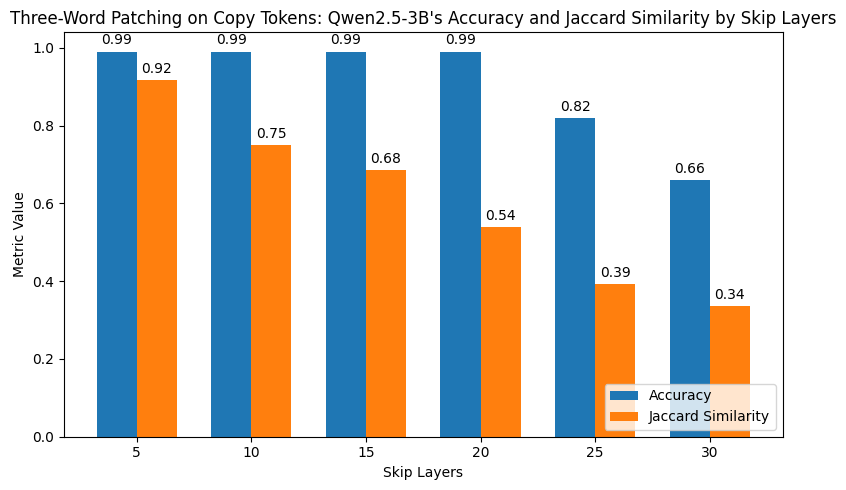

In [10]:
skip_layers = skip_up_to

plot_skip_layer_metrics(skip_layers, acc, jcc, model_name="Qwen2.5-3B", schema="Three-Word Patching on Copy Tokens")

# Plot on Dif Context

In [16]:
from datasets import load_from_disk
from tqdm import tqdm

# Load the dataset from disk
num_samples = 10000
subset = load_from_disk("/home/longnhat/workspace_phu/CopyMech/english_insertions")
prompt_list = []

base_sents = subset['train']['base_sentence'][:num_samples]
phrases = subset['train']['phrase'][:num_samples]
edited_sents = subset['train']['edited_sentence'][:num_samples]

import gc
del subset
gc.collect()

1904

In [13]:
import torch

def find_dif_pos(tensor: torch.Tensor, pos: int) -> int:
    """
    Given a tensor of shape (1, n) and an index pos, returns the index
    of the last occurrence (before the final element) of the tensor's final value,
    ensuring that the found index is different from pos.
    
    Example:
      tensor = [[31, 11, 22, 551, 11, 223, 42, 11]]
      pos = 1
      The final value is 11. The occurrences of 11 (excluding the last element) 
      are at positions 1 and 4. Since pos=1, we choose 4.
      
      Returns: 4
    """
    if pos is None:
        return None
    # Convert tensor to a 1D list (we assume tensor is of shape (1, n))
    row = tensor[0]
    final_val = row[-1].item()
    
    # Scan from the second-to-last element backwards
    for i in range(len(row) - 2, -1, -1):
        if row[i].item() == final_val and i != pos:
            return i
    return None  # or raise an error if not found

# Test example:
tensor = torch.tensor([[31, 11, 22, 551, 11, 223, 42, 11]])
pos = 1
output = find_dif_pos(tensor, pos)
print("Output:", output)  # Expected output: 4


Output: 4


In [11]:
def ngram(n, model, skip_up_to, max_steps, extra_steps, k, edited_phrases):

    print("n-gram: ", n)
    print("Skip layers: ", skip_up_to)

    info_lst = []
    failed_lst = []

    total_failed_by_prepocess = 0
    # total_failed_as_ulsolvable = 0
    total_solvable_og = 0
    total_unsolvable = 0
    total_matches = []

    num_matched = 0
    # total_steps = 0

    for edited in tqdm(edited_phrases):

        if total_solvable_og == 100:
            break

        if not has_required_spaces(edited, num_context = 10):
            continue

        # preprocess text
        edited = text_preprocess(edited)
        if edited is None:
            total_failed_by_prepocess += 1
            continue
        corrupted_text, pre_isare, correct_tobe = edited
        prompt = f"Please fix grammar of the following text: '{corrupted_text}'. The correct text is: {pre_isare}"

        # edited_ids = tokenizer.encode(edited, return_tensors='pt')
        # steps = extra_steps + edited_ids.size(1)
        # if steps > max_steps:
        #     steps = max_steps
        # total_steps += steps
        steps = 1

        dict_pred_info = defaultdict(dict)

        for step_i in range(steps):
            if step_i != 0:
                prompt_tokens = model.to_tokens(prompt, prepend_bos=False)
            else:
                prompt_tokens = model.to_tokens(prompt)

            _t_matched, _ = detect_ngram_copy(prompt_tokens, n=n, skip_up_to=skip_up_to)
            t_matched_1st = find_dif_pos(prompt_tokens, _t_matched)
            _t_matched, _ = detect_ngram_copy(prompt_tokens[:,:-1], n=n, skip_up_to=skip_up_to)
            t_matched_2nd = find_dif_pos(prompt_tokens[:,:-1], _t_matched)
            _t_matched, _ = detect_ngram_copy(prompt_tokens[:,:-2], n=n, skip_up_to=skip_up_to)
            t_matched_3rd = find_dif_pos(prompt_tokens[:,:-2], _t_matched)
            
            # detect copy scenario
            if t_matched_1st is not None and t_matched_2nd is not None and t_matched_3rd is not None:
                pos_matched = [t_matched_1st, t_matched_2nd, t_matched_3rd]
                pos_current = [len(prompt_tokens[0])-1, len(prompt_tokens[0])-2, len(prompt_tokens[0])-3]
                
                # run on the prompt once with cache to store activations to patch in later
                og_logits, og_cache = model.run_with_cache(prompt_tokens)
                # get the top k tokens
                og_topk_indices = get_top_k(og_logits, k)
                # get the highest prob token
                og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                # check if model can solve the task
                decoded_og_next_token = model.to_string(og_next_token)[0]
                if 'are' in decoded_og_next_token and correct_tobe == 'are':
                    total_solvable_og += 1
                elif 'is' in decoded_og_next_token and correct_tobe == 'is':
                    total_solvable_og += 1
                else:
                    total_unsolvable += 1
                    continue
            
                # num_matched += 1

                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    pos_matched: list,
                    pos_current: list
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, pos_current, :] = clean_resid_pre[:, pos_matched, :]
                    return resid_pre
                
                # Use functools.partial to create a temporary hook function with the position fixed
                temp_hook_fn = partial(residual_stream_patching_hook, pos_matched=pos_matched, pos_current=pos_current)
                # Run the model with the patching hook
                patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                    (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                ])

                # def v_patching_hook(
                #     resid_pre: Float[torch.Tensor, "batch pos head_index d_head"],
                #     hook: HookPoint,
                #     position: int
                # ) -> Float[torch.Tensor, "batch pos head_index d_head"]:
                #     # Each HookPoint has a name attribute giving the name of the hook.
                #     clean_resid_pre = og_cache[hook.name]
                #     resid_pre[:, -1, :, :] = clean_resid_pre[:, position, :, :]
                #     return resid_pre
                
                # for layer in range(skip_up_to):
                #     # Use functools.partial to create a temporary hook function with the position fixed
                #     temp_hook_fn = partial(v_patching_hook, position=t_matched)
                #     # Run the model with the patching hook
                #     patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                #         (utils.get_act_name("v", layer), temp_hook_fn)
                #     ])
                
                pt_topk_indices = get_top_k(patched_logits, k)
                # get the highest prob token
                pt_next_token = torch.tensor([pt_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                if torch.equal(og_next_token, pt_next_token):
                    total_matches.append(1)
                else:
                    total_matches.append(0)

                # # append the token to the sequence
                # pt_prompt_tokens = torch.cat([prompt_tokens, pt_next_token], dim=1)
                # # deocde the token
                # pt_prompt = model.to_string(pt_prompt_tokens)[0]      
                # print('PT:\n')
                # print(pt_prompt)

                dict_pred_info[step_i]['original'] = og_topk_indices
                dict_pred_info[step_i]['copy'] = get_top_k(patched_logits, k)
            else:
                total_solvable_og -= 1

        info_lst.append(dict_pred_info)
        
    jcc, acc = get_acc(info_lst)
    print("Avg jaccard similarity: ", jcc)
    print("Avg accuracy 2: ", acc)
    print("Avg accuracy 3: ", sum(total_matches) / len(total_matches))
    print("#Sample: ", len(total_matches))
    print('#Unsolvable: ', total_unsolvable)
    return jcc, acc, sum(total_matches) / len(total_matches)

In [17]:
seed = 5
extra_steps = 5
max_steps = 1024
k=100
seed_everything(seed)

jcc = []
acc = []

ns = [5]
skip_up_to = [5, 10, 15, 20, 25, 30]
# skip_up_to = [5,6,7,8,9,10]
info_lst = {}
for n in ns:
    info_lst[n] = {}
    for skip in skip_up_to:
        info_lst[n][skip] = {}
        outputs = ngram(n, model, skip, max_steps, extra_steps, k, edited_sents)
        jcc.append(outputs[0])
        acc.append(outputs[1])
        print("-----------------------------------")

n-gram:  5
Skip layers:  5


100%|██████████| 10000/10000 [00:05<00:00, 1852.64it/s]


Avg jaccard similarity:  0.7625872389284549
Avg accuracy 2:  0.8235294117647058
Avg accuracy 3:  0.8235294117647058
#Sample:  17
#Unsolvable:  29
-----------------------------------
n-gram:  5
Skip layers:  10


100%|██████████| 10000/10000 [00:05<00:00, 1871.98it/s]


Avg jaccard similarity:  0.6762974363316185
Avg accuracy 2:  0.5882352941176471
Avg accuracy 3:  0.5882352941176471
#Sample:  17
#Unsolvable:  29
-----------------------------------
n-gram:  5
Skip layers:  15


100%|██████████| 10000/10000 [00:05<00:00, 1870.77it/s]


Avg jaccard similarity:  0.5674957294770681
Avg accuracy 2:  0.47058823529411764
Avg accuracy 3:  0.47058823529411764
#Sample:  17
#Unsolvable:  29
-----------------------------------
n-gram:  5
Skip layers:  20


100%|██████████| 10000/10000 [00:05<00:00, 1833.93it/s]


Avg jaccard similarity:  0.4060673840537828
Avg accuracy 2:  0.35294117647058826
Avg accuracy 3:  0.35294117647058826
#Sample:  17
#Unsolvable:  29
-----------------------------------
n-gram:  5
Skip layers:  25


100%|██████████| 10000/10000 [00:05<00:00, 1864.23it/s]


Avg jaccard similarity:  0.30004632633136946
Avg accuracy 2:  0.17647058823529413
Avg accuracy 3:  0.17647058823529413
#Sample:  17
#Unsolvable:  29
-----------------------------------
n-gram:  5
Skip layers:  30


100%|██████████| 10000/10000 [00:05<00:00, 1853.27it/s]

Avg jaccard similarity:  0.21065321689508873
Avg accuracy 2:  0.0
Avg accuracy 3:  0.0
#Sample:  17
#Unsolvable:  29
-----------------------------------


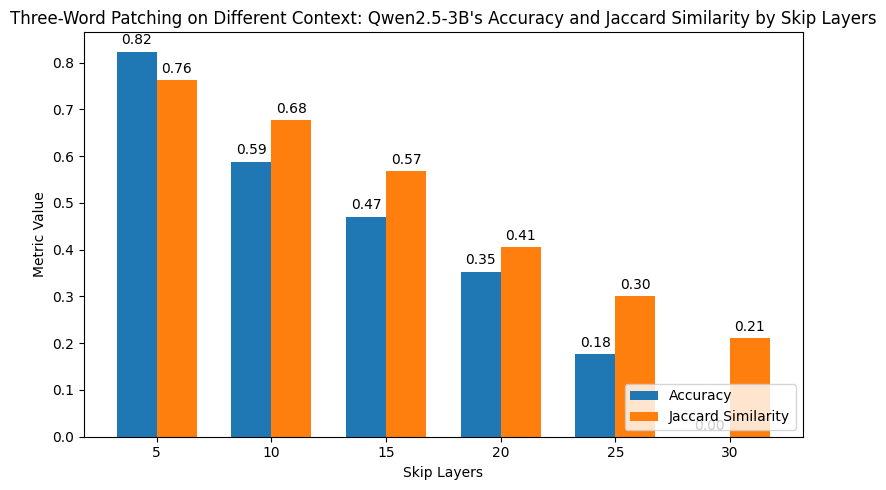

In [19]:
skip_layers = skip_up_to

plot_skip_layer_metrics(skip_layers, acc, jcc, model_name="Qwen2.5-3B", schema="Three-Word Patching on Different Context")